In [1]:
import os
import pathlib
import string
import pickle
import re

import pandas as pd
import numpy as np

In [2]:
# with open('Fruits.obj', 'wb') as fp:
#     pickle.dump(banana, fp)

# with open('Fruits.obj', 'rb') as fp:
#     banana = pickle.load(fp)

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.9)

# Data preprocessing

In [5]:
preproc_data_path = "../data/wmt21/preprocessed_data/wmt21_preprocessed_full_data.tsv"
full_df = pd.read_csv(preproc_data_path, sep='\t')
full_df

system_name  seg_id            doc  \
0       Facebook-AI       1  rt.com.131279   
1         HuaweiTSC       1  rt.com.131279   
2              Nemo       1  rt.com.131279   
3              Nemo       1  rt.com.131279   
4          Online-W       1  rt.com.131279   
...             ...     ...            ...   
8345  metricsystem1    1002  sky.com.33889   
8346  metricsystem2    1002  sky.com.33889   
8347  metricsystem3    1002  sky.com.33889   
8348  metricsystem4    1002  sky.com.33889   
8349  metricsystem5    1002  sky.com.33889   

                                                 source  \
0     Couple MACED at California dog park for not we...   
1     Couple MACED at California dog park for not we...   
2     Couple MACED at California dog park for not we...   
3     Couple MACED at California dog park for not we...   
4     Couple MACED at California dog park for not we...   
...                                                 ...   
8345  Wiley, known as the Godfather of Grime and who...   
8346  Wiley, known as the Godfather of Grime and who...   
8347  Wiley, known as the Godfather of Grime and who...   
8348  Wiley, known as the Godfather of Grime and who...   
8349  Wiley, known as the Godfather of Grime and who...   

                                                 target    rater  \
0     Paar <v>MACED</v> im kalifornischen Hundepark,...   rater2   
1     Paar <v>MACED</v> im kalifornischen Hundepark,...   rater4   
2     <v>Paar MACED im kalifornischen Hundepark für ...   rater4   
3     Paar <v>MACED</v> im kalifornischen Hundepark ...   rater4   
4     Paar <v>MACED</v> in Kalifornien Hundepark für...  rater11   
...                                                 ...      ...   
8345  Wiley, bekannt als Godfather of Grime und mit ...   rater9   
8346  Wiley, bekannt als der <v>Pate des Schmutzes <...  rater13   
8347  Wiley, bekannt als Godfather of Grime und mit ...  rater11   
8348  Wiley, bekannt als Godfather of Grime und mit ...   rater1   
8349  <v>Wiley, der als Pate von Grime bekannt ist u...  rater13   

      mqm_avg_score                   category  severity comment  \
0              -5.0    Accuracy/Mistranslation     Major     NaN   
1              -5.0      Accuracy/Untranslated     Major     NaN   
2              -6.0              Style/Awkward     Minor     NaN   
3              -6.0      Accuracy/Untranslated     Major     NaN   
4              -5.0    Accuracy/Mistranslation     Major     NaN   
...             ...                        ...       ...     ...   
8345           -2.0              Style/Awkward     Minor     NaN   
8346           -5.0              Style/Awkward     Major     NaN   
8347           -0.0                   No-error  No-error     NaN   
8348           -0.0                   No-error  No-error     NaN   
8349           -5.0  Terminology/Inappropriate     Major     NaN   

                                              reference  \
0     Angriff mit Pfefferspray auf ein Paar in einem...   
1     Angriff mit Pfefferspray auf ein Paar in einem...   
2     Angriff mit Pfefferspray auf ein Paar in einem...   
3     Angriff mit Pfefferspray auf ein Paar in einem...   
4     Angriff mit Pfefferspray auf ein Paar in einem...   
...                                                 ...   
8345  Wiley, bekannt als „Godfather of Grime“, desse...   
8346  Wiley, bekannt als „Godfather of Grime“, desse...   
8347  Wiley, bekannt als „Godfather of Grime“, desse...   
8348  Wiley, bekannt als „Godfather of Grime“, desse...   
8349  Wiley, bekannt als „Godfather of Grime“, desse...   

                                              mt_output  z_mqm_score  
0     Paar MACED im kalifornischen Hundepark, weil e...    -0.013807  
1     Paar MACED im kalifornischen Hundepark, weil e...    -0.858404  
2     Paar MACED im kalifornischen Hundepark für das...    -1.182732  
3     Paar MACED im kalifornischen Hundepark für das...    -1.182732  
4     Paar MACED in Kalifornien Hundepark für ni

In [7]:
mt_systems = full_df.system_name.unique()
mt_systems

array(['Facebook-AI', 'HuaweiTSC', 'Nemo', 'Online-W', 'UEdin',
       'VolcTrans-AT', 'VolcTrans-GLAT', 'eTranslation', 'metricsystem1',
       'metricsystem2', 'metricsystem3', 'metricsystem4', 'metricsystem5'],
      dtype=object)

In [ ]:
# with open('Fruits.obj', 'wb') as fp:
#     pickle.dump(banana, fp)

---


# Data analysis

In [8]:
import torch

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
dler = nltk.downloader.Downloader()
dler._update_index()
dler.download('omw-1.4')
# dler.download('all')

[nltk_data] Downloading package punkt to /home/ira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ira/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

__Data__:
- refs : reference translation from ref. systym C
- hyps : MT output
- mqm_scores : mqm numerical scores from wmt21
- mqm_z_scores : normalized mqm scores

In [9]:
PUNCTUATION = set(string.punctuation)
PUNCTUATION.add('...')
PUNCTUATION.add('„')
PUNCTUATION.add('“')

In [10]:
# From sacre_bleu
def separate_punctuation(sent, lowercase) -> str:
    """Separates out punctuations from beginning and end of words.
    
    :param sent: string
    :param lowercase: boolean
    
    :return: string
    """
    
    if lowercase == True:
        sent = sent.lower()
        
    tokenized = []
    for w in sent.split():
        if w == '':
            continue
        elif w in PUNCTUATION:
            tokenized.append(w)
        else: 
            end_puncts = []
            if w[-3:] in PUNCTUATION:
                end_puncts.append(w[-3:])
                w = w[:-3]
                
            while len(w) > 0 and w[0] in PUNCTUATION:
                tokenized.append(w[0])
                w = w[1:]
            
            while len(w) > 0 and w[-1] in PUNCTUATION:
                end_idx = -1
                end_puncts.append(w[end_idx:])
                w = w[:end_idx]
                    
            if len(w) > 0:
                hyp_idx = w.find('-')
                if hyp_idx > -1:
                    tokenized.append(w[:hyp_idx])
                    if (hyp_idx+1) < len(w):
                        tokenized.append(w[hyp_idx+1:])
                else:
                    tokenized.append(w)
            
            if len(end_puncts) > 0:
                end_puncts.reverse()
                tokenized = tokenized + list(end_puncts)
            
    return ' '.join(tokenized)

In [11]:
def bring_to_long_form(s):
    s = re.sub(' won\'t ', ' will not ', s)
    s = re.sub('n\'t ', ' not ', s)
    s = re.sub('\'re ', ' are ', s)
    s = re.sub(' it\'s ', ' it is ', s)
    if s.startswith('it\'s '):
        s = re.sub('it\'s ', 'it is ', s)
    return s

In [12]:
def rmv_punkt(s):
    for char in PUNCTUATION:
        s = s.replace(char, '')
    return s

In [13]:
def custom_preprocess(s, lowercase, long_form, remove_punkt):
    s = separate_punctuation(s, lowercase)
    if long_form:
        s = bring_to_long_form(s)
    if remove_punkt:
        s = rmv_punkt(s)
    return s

In [16]:
ref_snts = full_df.reference
mt_snts = full_df.mt_output

In [17]:
ref_snts = [custom_preprocess(s, True, False, False) for s in ref_snts]
ref_tokens = [word_tokenize(s) for s in ref_snts]

In [18]:
mt_snts = [custom_preprocess(s, True, False, False) for s in mt_snts]
mt_tokens = [word_tokenize(s) for s in mt_snts]

In [19]:
src_snts = full_df.source
src_snts = [custom_preprocess(s, True, False, False) for s in src_snts]

In [20]:
import re
# s = 'abv . . . . .'
# re.sub(r'(\. )+', '', s)

mt_snts = [re.sub(r'( )+', ' ', re.sub(r'(\. \.)+', '', s)) for s in mt_snts]
ref_snts = [re.sub(r'( )+', ' ', re.sub(r'(\. \.)+', '', s)) for s in ref_snts]

In [22]:
with open('all_ref_snts_21.pickle', 'wb') as fp:
    pickle.dump(ref_snts, fp)

In [23]:
with open('all_mt_snts_21.pickle', 'wb') as fp:
    pickle.dump(mt_snts, fp)

In [24]:
with open('all_src_snts_21.pickle', 'wb') as fp:
    pickle.dump(src_snts, fp)

In [47]:
with open('all_ref_snts_21.txt', 'w') as f:
    for line in ref_snts:
        f.write(f"{line}\n")

with open('all_mt_snts_21.txt', 'w') as f:
    for line in mt_snts:
        f.write(f"{line}\n")

In [55]:
# Input for TERp:

with open('all_ref_snts_21.trans', 'w') as f:
    for i, line in enumerate(ref_snts):
        f.write(f"{line} ([sys][doc][{i+1}])\n")

with open('all_mt_snts_21.trans', 'w') as f:
    for i, line in enumerate(mt_snts):
        f.write(f"{line} ([sys][doc][{i+1}])\n")

In [219]:
z_mqm_scores = full_df['z_mqm_score'].values
with open('all_z_mqm_scores.pickle', 'wb') as fp:
    pickle.dump(z_mqm_scores, fp)

### Load data

In [41]:
import os
import pickle
import pandas as pd
import numpy as np

wmt_data_folder = '../data/wmt21/preprocessed_data'

ref_path = os.path.join(wmt_data_folder, 'all_ref_snts_21.pickle')
mt_path = os.path.join(wmt_data_folder, 'all_mt_snts_21.pickle')
srs_path = os.path.join(wmt_data_folder, 'all_src_snts_21.pickle')
mqm_scores_path = os.path.join(wmt_data_folder, 'all_z_mqm_scores.pickle')
    
with open(ref_path, 'rb') as fp:
    ref_snts = pickle.load(fp)

with open(mt_path, 'rb') as fp:
    mt_snts = pickle.load(fp)

with open(mqm_scores_path, 'rb') as fp:
    human_scores = pickle.load(fp)

with open(srs_path, 'rb') as fp:
    src_snts = pickle.load(fp)

In [45]:
ref_tokens = [s.split() for s in ref_snts]
mt_tokens = [s.split() for s in mt_snts]
src_tokens = [str(s).split() for s in src_snts]

In [15]:
precomputed_scores_dir = '../data/precomputed_metric_scores_for_wmt21_all'    

## Compute metric scores

In [16]:
metric_scores = pd.DataFrame(data={'mqm_score': full_df.mqm_avg_score, 
                                   'z_mqm_score': full_df.z_mqm_score, 
                                   'mt_system': full_df.system_name})
metric_scores

mqm_score  z_mqm_score      mt_system
0          -5.0    -0.013807    Facebook-AI
1          -5.0    -0.858404      HuaweiTSC
2          -6.0    -1.182732           Nemo
3          -6.0    -1.182732           Nemo
4          -5.0    -0.561254       Online-W
...         ...          ...            ...
8345       -2.0     0.342346  metricsystem1
8346       -5.0     0.080083  metricsystem2
8347       -0.0     0.709702  metricsystem3
8348       -0.0     0.326909  metricsystem4
8349       -5.0     0.080083  metricsystem5

[8350 rows x 3 columns]

### Metrics from SacreBleu

In [17]:
import sacrebleu as sb

sb_chrf = sb.CHRF()
sb_ter = sb.TER()
sb_bleu = sb.BLEU()

sb_bleu.effective_order = True
metric_scores['sacre_bleu'] = [sb_bleu.sentence_score(mt_snts[i], [ref_snts[i]]).score / 100 for i in range(len(mt_snts))]
metric_scores['sacre_chrf'] = [sb_chrf.sentence_score(mt_snts[i], [ref_snts[i]]).score / 100 for i in range(len(mt_snts))]
metric_scores['sacre_ter'] = [(100 - sb_ter.sentence_score(mt_snts[i], [ref_snts[i]]).score) / 100 for i in range(len(mt_snts))]

metric_scores

mqm_score  z_mqm_score      mt_system  sacre_bleu  sacre_chrf  sacre_ter
0          -5.0    -0.013807    Facebook-AI    0.310978    0.485126   0.481481
1          -5.0    -0.858404      HuaweiTSC    0.166685    0.454055   0.444444
2          -6.0    -1.182732           Nemo    0.092059    0.408957   0.296296
3          -6.0    -1.182732           Nemo    0.092059    0.408957   0.296296
4          -5.0    -0.561254       Online-W    0.128462    0.486589   0.407407
...         ...          ...            ...         ...         ...        ...
8345       -2.0     0.342346  metricsystem1    0.299924    0.640811   0.615385
8346       -5.0     0.080083  metricsystem2    0.269947    0.538037   0.500000
8347       -0.0     0.709702  metricsystem3    0.299924    0.640811   0.615385
8348       -0.0     0.326909  metricsystem4    0.299924    0.640811   0.615385
8349       -5.0     0.080083  metricsystem5    0.201202    0.511776   0.423077

[8350 rows x 6 columns]

In [425]:
import sacrebleu
print(sacrebleu.__version__)

2.0.0


In [426]:
print("BLEU signature:\n", sb_bleu.get_signature())
print("ChrF signature:\n", sb_chrf.get_signature())
print("TER signature:\n", sb_ter.get_signature())

BLEU signature:
 nrefs:1|case:mixed|eff:yes|tok:13a|smooth:exp|version:2.0.0
ChrF signature:
 nrefs:1|case:mixed|eff:yes|nc:6|nw:0|space:no|version:2.0.0
TER signature:
 nrefs:1|case:lc|tok:tercom|norm:no|punct:yes|asian:no|version:2.0.0


### Metrics from NLTK library

In [18]:
from nltk.translate import meteor_score, bleu_score, chrf_score, nist_score, ribes_score
from nltk.util import ngrams

In [21]:
# METEOR

metric_scores['nltk_meteor'] = [meteor_score.meteor_score([ref_tokens[i]], mt_tokens[i]) for i in range(len(ref_tokens))]

In [49]:
# NIST

metric_scores['nltk_nist'] = [nist_score.sentence_nist([ref_tokens[i]], mt_tokens[i], n=1) for i in range(len(ref_tokens))]

In [50]:
metric_scores.corr()

mqm_score  z_mqm_score  sacre_bleu  sacre_chrf  sacre_ter  \
mqm_score     1.000000     0.799385    0.122258    0.138634   0.155538   
z_mqm_score   0.799385     1.000000    0.152896    0.179027   0.185955   
sacre_bleu    0.122258     0.152896    1.000000    0.826729   0.829111   
sacre_chrf    0.138634     0.179027    0.826729    1.000000   0.742083   
sacre_ter     0.155538     0.185955    0.829111    0.742083   1.000000   
nltk_meteor   0.148950     0.178730    0.869799    0.871609   0.833375   
nltk_nist     0.012735     0.026173    0.712564    0.681957   0.763120   

             nltk_meteor  nltk_nist  
mqm_score       0.148950   0.012735  
z_mqm_score     0.178730   0.026173  
sacre_bleu      0.869799   0.712564  
sacre_chrf      0.871609   0.681957  
sacre_ter       0.833375   0.763120  
nltk_meteor     1.000000   0.781343  
nltk_nist       0.781343   1.000000

In [51]:
# RIBES
ribes_path = os.path.join(precomputed_scores_dir, 'all_ribes_scores_21.pickle')
with open(ribes_path, 'rb') as f:
    ribes_scores = pickle.load(f)    
metric_scores['nltk_ribes'] = ribes_scores

### HLEPOR 

In [52]:
from hlepor import single_hlepor_score, hlepor_score
metric_scores['hlepor'] = [single_hlepor_score(ref_snts[i], mt_snts[i]) for i in range(len(ref_snts))]

[nltk_data] Downloading package punkt to /home/ira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### BERTScore

In [53]:
# check if model used supported German
bertscore_path = os.path.join(precomputed_scores_dir, 'bert_scores_21_xlm-roberta-large.pickle')
with open(bertscore_path, 'rb') as f:
    bert_scores = pickle.load(f)
metric_scores['bert_roberta_f1'] = bert_scores['F1']
metric_scores['bert_roberta_r'] = bert_scores["R"]
metric_scores['bert_roberta_p'] = bert_scores["P"]

In [ ]:
metric_scores

### BLEURT 

In [54]:
bleurt_path = os.path.join(precomputed_scores_dir, 'all_bleurt_scores_wmt21.pickle')

with open(bleurt_path, 'rb') as f:
    bleurt_scores = pickle.load(f)

In [55]:
bleurt_scores = np.asarray(bleurt_scores)
metric_scores['bleurt'] = bleurt_scores

# bleurt_mu = np.mean(bleurt_scores)
# bleurt_sigma = np.std(bleurt_scores)

# z_score_f = lambda t: (t - bleurt_mu) / bleurt_sigma
# v_z_score_f = np.vectorize(z_score_f)
# z_bleurt_scores = v_z_score_f(bleurt_scores)
# metric_scores['z_bleurt'] = z_bleurt_scores

### BEER

In [56]:
beer_path = os.path.join(precomputed_scores_dir, 'all_beer_scores_21.txt')
with open(beer_path, 'r') as f:
    beer_scores = f.readlines()
beer_scores = [float(s.split(' ')[-1][:-1]) for s in beer_scores[:-1]] # the last line contains total score

In [57]:
metric_scores['beer'] = beer_scores

### PRISM

In [58]:
prism_path = os.path.join(precomputed_scores_dir, 'all_prism_scores_wmt21.pickle')
with open(prism_path, 'rb') as f:
    prism_scores = pickle.load(f)
metric_scores['prism_ref'] = prism_scores['prism_ref']
metric_scores['prism_src'] = prism_scores['prism_src']

### ROUGE

In [60]:
# with open('all_rouge_1_f1_wmt21.pickle', 'rb') as f:
#     rouge_scores = pickle.load(f)

rouge_path = os.path.join(precomputed_scores_dir, 'all_rouge_scores_wmt21_tokenized_and_lowercase.pickle')
with open(rouge_path, 'rb') as f:
    rouge_scores = pickle.load(f)

for k, scores in rouge_scores.items():    
    scores = [s / 100 for s in scores]
    rouge_scores[k] = scores
metric_scores['rouge_1_f1'] = rouge_scores['rouge1_f1']
metric_scores['rouge_1_p'] = rouge_scores['rouge1_p']
metric_scores['rouge_1_r'] = rouge_scores['rouge1_r']
metric_scores['rouge_l_f1'] = rouge_scores['rougel_f1']

### GTM

In [61]:
gtm_path = os.path.join(precomputed_scores_dir, 'all_gtm_scores_21.txt')

with open(gtm_path, 'r') as f:
    gtm_report = f.readlines()
gtm_scores = []
for l in gtm_report:
    if 'sampledoc' in l:
        scores = l[:-1].split(' ')
        if len(scores) == 3:
            score = float(scores[2])
            gtm_scores.append(score)
metric_scores['gtm'] = gtm_scores

### YISI

### TERp

In [62]:
terp_path = os.path.join(precomputed_scores_dir, 'terpa.simple21_all.seg.scr')
terp_scores = pd.read_csv(terp_path, sep='\t', header=None, names=['sys_id', 'col', 'doc_id', 'seg_id', 'terp','words_count'])
terp_scores = terp_scores[['terp','words_count']]
terp_scores['words_count'] = terp_scores['words_count'].apply(lambda x: int(x))
terp_scores

terp  words_count
0     0.662983           27
1     0.720633           27
2     1.000000           27
3     1.000000           27
4     0.794299           27
...        ...          ...
8345  0.588702           26
8346  0.713407           26
8347  0.588702           26
8348  0.588702           26
8349  0.749966           26

[8350 rows x 2 columns]

In [63]:
metric_scores['terp'] = 1 - terp_scores['terp'].values

### MoverScore

In [64]:
mover_score_path = os.path.join(precomputed_scores_dir, 'mover_scores_21_xlm-roberta-large.pickle')

with open(mover_score_path, 'rb') as f:
    mover_scores = pickle.load(f)
metric_scores['mover_score'] = mover_scores

### COMET

In [65]:
comet_path = os.path.join(precomputed_scores_dir, 'all_comet_scores_df_21.pickle')
with open(comet_path, 'rb') as f:
    comet_scores_df = pickle.load(f)
comet_scores_df

z_mqm_scores  comet_reg_da  comet_reg_mqm
0        -0.013807     -0.759673       0.016829
1        -0.858404     -0.765728       0.016492
2        -1.182732     -0.850904       0.015186
3        -1.182732     -0.850904       0.015186
4        -0.561254     -0.931326       0.016496
...            ...           ...            ...
8345      0.342346      0.715877       0.036771
8346      0.080083     -0.314926       0.025257
8347      0.709702      0.715831       0.036779
8348      0.326909      0.715831       0.036779
8349      0.080083      0.434510       0.031601

[8350 rows x 3 columns]

In [66]:
metric_scores['comet_reg_da_20'] = comet_scores_df['comet_reg_da']
metric_scores['comet_reg_mqm_21'] = comet_scores_df['comet_reg_mqm']
# metric_scores['comet_mqm_ref_less_21'] = comet_scores_df['comet_mqm_ref_less_21']

In [420]:
unique_scores_df[['z_mqm_score', 'comet_reg_da_20', 'comet_reg_mqm_21', 'bleurt']].corr()

z_mqm_score  comet_reg_da_20  comet_reg_mqm_21
z_mqm_score          1.000000         0.340881          0.324410
comet_reg_da_20      0.340881         1.000000          0.612291
comet_reg_mqm_21     0.324410         0.612291          1.000000

In [422]:
metric_scores[['z_mqm_score', 'comet_reg_da_20', 'comet_reg_mqm_21', 'bleurt']].corr()

z_mqm_score  comet_reg_da_20  comet_reg_mqm_21    bleurt
z_mqm_score          1.000000         0.393155          0.414703  0.409601
comet_reg_da_20      0.393155         1.000000          0.634041  0.779225
comet_reg_mqm_21     0.414703         0.634041          1.000000  0.689385
bleurt               0.409601         0.779225          0.689385  1.000000

In [67]:
metric_scores

mqm_score  z_mqm_score      mt_system  sacre_bleu  sacre_chrf  \
0          -5.0    -0.013807    Facebook-AI    0.310978    0.485126   
1          -5.0    -0.858404      HuaweiTSC    0.166685    0.454055   
2          -6.0    -1.182732           Nemo    0.092059    0.408957   
3          -6.0    -1.182732           Nemo    0.092059    0.408957   
4          -5.0    -0.561254       Online-W    0.128462    0.486589   
...         ...          ...            ...         ...         ...   
8345       -2.0     0.342346  metricsystem1    0.299924    0.640811   
8346       -5.0     0.080083  metricsystem2    0.269947    0.538037   
8347       -0.0     0.709702  metricsystem3    0.299924    0.640811   
8348       -0.0     0.326909  metricsystem4    0.299924    0.640811   
8349       -5.0     0.080083  metricsystem5    0.201202    0.511776   

      sacre_ter  nltk_meteor  nltk_nist  nltk_ribes    hlepor  ...  prism_src  \
0      0.481481     0.559780   2.276816    0.300881  0.586640  ...  -2.312312   
1      0.444444     0.511368   2.114186    0.133387  0.553841  ...  -2.230361   
2      0.296296     0.314061   1.338224    0.132567  0.409013  ...  -2.627440   
3      0.296296     0.314061   1.338224    0.132567  0.409013  ...  -2.627440   
4      0.407407     0.471792   1.901719    0.111794  0.549411  ...  -2.166730   
...         ...          ...        ...         ...       ...  ...        ...   
8345   0.615385     0.581395   2.880997    0.152584  0.708601  ...  -1.942878   
8346   0.500000     0.508721   2.499732    0.194703  0.581850  ...  -2.586133   
8347   0.615385     0.581395   2.880997    0.152584  0.708601  ...  -1.942878   
8348   0.615385     0.581395   2.880997    0.152584  0.708601  ...  -1.942878   
8349   0.423077     0.488226   2.370624    0.121437  0.618557  ...  -2.502893   

      rouge_1_f1  rouge_1_p  rouge_1_r  rouge_l_f1       gtm      terp  \
0        0.55000    0.68750    0.45833     0.55000  0.595745  0.337017   
1        0.55000    0.68750    0.45833     0.55000  0.553191  0.279367   
2        0.38095    0.44444    0.33333     0.38095  0.391304  0.000000   
3        0.38095    0.44444    0.33333     0.38095  0.391304  0.000000   
4        0.57143    0.66667    0.50000     0.52381  0.565217  0.205701   
...          ...        ...        ...         ...       ...       ...   
8345     0.68085    0.69565    0.66667     0.68085  0.640000  0.411298   
8346     0.51064    0.52174    0.50000     0.51064  0.560000  0.286593   
8347     0.68085    0.69565    0.66667     0.68085  0.640000  0.411298   
8348     0.68085    0.69565    0.66667     0.68085  0.640000  0.411298   
8349     0.52000    0.50000    0.54167     0.48000  0.538462  0.250034   

      mover_score  comet_reg_da_20  comet_reg_mqm_21  
0        0.935223        -0.759673          0.016829  
1        0.926463        -0.765728          0.016492  
2        0.911528        -0.850904          0.015186  
3        0.911528        -0.850904          0.015186  
4        0.922788        -0.931326          0.016496  
...           ...              ...               ...  
8345     0.941740         0.715877          0.036771  
8346     0.935292        -0.314926          0.025257  
8347     0.941740         0.715831          0.036779  
8348     0.941740         0.715831          0.036779  
8349     0.940829         0.434510          0.031601  

[8350 rows x 26 columns]

### Some preprocessing

In [68]:
metric_scores['seg_id'] = full_df['seg_id'].values

In [69]:
unique_scores_df = metric_scores.drop_duplicates(subset=['seg_id', 'mt_system'])

In [70]:
unique_scores_df.reset_index(inplace=True, drop=True)

In [394]:
mt_systems = unique_scores_df.mt_system.unique()
mt_systems

array(['Facebook-AI', 'HuaweiTSC', 'Nemo', 'Online-W', 'UEdin',
       'VolcTrans-AT', 'VolcTrans-GLAT', 'eTranslation', 'metricsystem1',
       'metricsystem2', 'metricsystem3', 'metricsystem4', 'metricsystem5'],
      dtype=object)

In [71]:
columns = ['mqm_score', 'z_mqm_score', 'sacre_bleu', 'nltk_nist', 'gtm', 
           'rouge_1_f1', 'rouge_1_p', 'rouge_1_r', 'rouge_l_f1',
           'hlepor', 'nltk_meteor', 'sacre_chrf', 'sacre_ter', 'terp',
           'nltk_ribes', 'beer', 'prism_ref', 'prism_src', 
           'bert_roberta_f1', 'bert_roberta_p','bert_roberta_r', 'mover_score', 'bleurt', 
           'comet_reg_da_20', 'comet_reg_mqm_21']

In [192]:
# Group by system and average scores

In [72]:
mean_scores_df = unique_scores_df.groupby(['mt_system'])[columns].mean()

In [73]:
unique_scores_df

mqm_score  z_mqm_score      mt_system  sacre_bleu  sacre_chrf  \
0          -5.0    -0.013807    Facebook-AI    0.310978    0.485126   
1          -5.0    -0.858404      HuaweiTSC    0.166685    0.454055   
2          -6.0    -1.182732           Nemo    0.092059    0.408957   
3          -5.0    -0.561254       Online-W    0.128462    0.486589   
4         -10.0    -0.782797          UEdin    0.103923    0.416273   
...         ...          ...            ...         ...         ...   
6846       -2.0     0.342346  metricsystem1    0.299924    0.640811   
6847       -5.0     0.080083  metricsystem2    0.269947    0.538037   
6848       -0.0     0.709702  metricsystem3    0.299924    0.640811   
6849       -0.0     0.326909  metricsystem4    0.299924    0.640811   
6850       -5.0     0.080083  metricsystem5    0.201202    0.511776   

      sacre_ter  nltk_meteor  nltk_nist  nltk_ribes    hlepor  ...  \
0      0.481481     0.559780   2.276816    0.300881  0.586640  ...   
1      0.444444     0.511368   2.114186    0.133387  0.553841  ...   
2      0.296296     0.314061   1.338224    0.132567  0.409013  ...   
3      0.407407     0.471792   1.901719    0.111794  0.549411  ...   
4      0.370370     0.427757   1.788927    0.105834  0.484976  ...   
...         ...          ...        ...         ...       ...  ...   
6846   0.615385     0.581395   2.880997    0.152584  0.708601  ...   
6847   0.500000     0.508721   2.499732    0.194703  0.581850  ...   
6848   0.615385     0.581395   2.880997    0.152584  0.708601  ...   
6849   0.615385     0.581395   2.880997    0.152584  0.708601  ...   
6850   0.423077     0.488226   2.370624    0.121437  0.618557  ...   

      rouge_1_f1  rouge_1_p  rouge_1_r  rouge_l_f1       gtm      terp  \
0        0.55000    0.68750    0.45833     0.55000  0.595745  0.337017   
1        0.55000    0.68750    0.45833     0.55000  0.553191  0.279367   
2        0.38095    0.44444    0.33333     0.38095  0.391304  0.000000   
3        0.57143    0.66667    0.50000     0.52381  0.565217  0.205701   
4        0.45000    0.56250    0.37500     0.45000  0.468085  0.164067   
...          ...        ...        ...         ...       ...       ...   
6846     0.68085    0.69565    0.66667     0.68085  0.640000  0.411298   
6847     0.51064    0.52174    0.50000     0.51064  0.560000  0.286593   
6848     0.68085    0.69565    0.66667     0.68085  0.640000  0.411298   
6849     0.68085    0.69565    0.66667     0.68085  0.640000  0.411298   
6850     0.52000    0.50000    0.54167     0.48000  0.538462  0.250034   

      mover_score  comet_reg_da_20  comet_reg_mqm_21  seg_id  
0        0.935223        -0.759673          0.016829       1  
1        0.926463        -0.765728          0.016492       1  
2        0.911528        -0.850904          0.015186       1  
3        0.922788        -0.931326          0.016496       1  
4        0.896092        -0.898371          0.016981       1  
...           ...              ...               ...     ...  
6846     0.941740         0.715877          0.036771    1002  
6847     0.935292        -0.314926          0.025257    1002  
6848     0.941740         0.715831          0.036779    1002  
6849     0.941740         0.715831          0.036779    1002  
6850     0.940829         0.434510          0.031601    1002  

[6851 rows x 27 columns]

---

## Correlation on system level

In [74]:
mean_scores_df

mqm_score  z_mqm_score  sacre_bleu  nltk_nist       gtm  \
mt_system                                                                 
Facebook-AI     -1.051992     0.454812    0.396500   2.994213  0.697309   
HuaweiTSC       -1.380835     0.232934    0.368914   2.934011  0.682790   
Nemo            -1.339848     0.251270    0.368830   2.944666  0.683218   
Online-W        -1.459962     0.276222    0.396195   2.939034  0.688952   
UEdin           -1.507400     0.206531    0.361663   2.905482  0.676319   
VolcTrans-AT    -1.743264     0.258954    0.351742   2.883877  0.673134   
VolcTrans-GLAT  -1.039089     0.329129    0.406988   3.021016  0.700634   
eTranslation    -1.695446     0.183243    0.362161   2.909175  0.676156   
metricsystem1   -2.072296     0.266505    0.351223   2.840493  0.665189   
metricsystem2   -2.584061     0.076484    0.328243   2.775014  0.649951   
metricsystem3   -2.271347     0.164084    0.321603   2.726886  0.643366   
metricsystem4   -2.047628     0.187867    0.347984   2.834306  0.665541   
metricsystem5   -2.612334     0.082639    0.334632   2.797002  0.654754   

                rouge_1_f1  rouge_1_p  rouge_1_r  rouge_l_f1    hlepor  ...  \
mt_system                                                               ...   
Facebook-AI       0.692571   0.697369   0.691969    0.653965  0.759014  ...   
HuaweiTSC         0.674941   0.688285   0.666479    0.634548  0.742825  ...   
Nemo              0.677514   0.687962   0.671712    0.636080  0.744227  ...   
Online-W          0.699319   0.706165   0.696702    0.661652  0.747948  ...   
UEdin             0.666146   0.675832   0.660938    0.624243  0.738188  ...   
VolcTrans-AT      0.665394   0.672245   0.663031    0.621192  0.739552  ...   
VolcTrans-GLAT    0.693124   0.700009   0.690224    0.656336  0.759891  ...   
eTranslation      0.668204   0.679168   0.661928    0.625470  0.737440  ...   
metricsystem1     0.667931   0.683864   0.657563    0.626502  0.720516  ...   
metricsystem2     0.655105   0.669894   0.645728    0.611540  0.707219  ...   
metricsystem3     0.648573   0.664464   0.638790    0.603598  0.700118  ...   
metricsystem4     0.668944   0.687285   0.656658    0.628142  0.720832  ...   
metricsystem5     0.662806   0.672324   0.658860    0.618603  0.715873  ...   

                    beer  prism_ref  prism_src  bert_roberta_f1  \
mt_system                                                         
Facebook-AI     0.693841  -2.287385  -2.131449         0.761101   
HuaweiTSC       0.682347  -2.325127  -2.113034         0.746418   
Nemo            0.682202  -2.314033  -2.120411         0.747400   
Online-W        0.692817  -2.299720  -2.157139         0.759650   
UEdin           0.676803  -2.328951  -2.065996         0.738493   
VolcTrans-AT    0.675808  -2.328778  -2.080916         0.738345   
VolcTrans-GLAT  0.697814  -2.291472  -2.180160         0.763398   
eTranslation    0.676746  -2.351802  -2.116526         0.737865   
metricsystem1   0.672801  -2.351843  -2.118954         0.738855   
metricsystem2   0.662326  -2.387137  -2.115196         0.727889   
metricsystem3   0.656422  -2.404834  -2.149165         0.722370   
metricsystem4   0.672632  -2.355347  -2.096430         0.736979   
metricsystem5   0.666099  -2.376236  -2.101855         0.727503   

                bert_roberta_p  bert_roberta_r  mover_score    bleurt  \
mt_system                                                               
Facebook-AI           0.765364        0.756084     0.912508  0.650109   
HuaweiTSC             0.751199        0.740830     0.909941  0.626869   
Nemo                  0.750625        0.743347     0.910694  0.633017   
Online-W              0.760673        0.757835     0.908536  0.651450   
UEdin                 0.740865        0.735249     0.910471  0.621398   
VolcTrans-AT          0.738155        0.737692     0.910139  0.621107   
VolcTrans-GLAT        0.766066        0.759958     0.913193  0.652959   
eTranslation          0.741465        0.7

In [75]:
mean_scores_df.corr()

mqm_score  z_mqm_score  sacre_bleu  nltk_nist       gtm  \
mqm_score          1.000000     0.843325    0.903781   0.943472  0.947516   
z_mqm_score        0.843325     1.000000    0.812396   0.784014  0.820066   
sacre_bleu         0.903781     0.812396    1.000000   0.953470  0.975931   
nltk_nist          0.943472     0.784014    0.953470   1.000000  0.993511   
gtm                0.947516     0.820066    0.975931   0.993511  1.000000   
rouge_1_f1         0.795195     0.765495    0.962829   0.873677  0.913409   
rouge_1_p          0.738487     0.715883    0.911098   0.803034  0.850567   
rouge_1_r          0.797043     0.769628    0.959068   0.882524  0.916894   
rouge_l_f1         0.796670     0.764952    0.964945   0.871841  0.912300   
hlepor             0.940093     0.799077    0.945521   0.989322  0.988417   
nltk_meteor        0.906579     0.806048    0.989160   0.966057  0.983638   
sacre_chrf         0.849024     0.788301    0.985949   0.928920  0.957090   
sacre_ter          0.962220     0.809216    0.934303   0.976084  0.974519   
terp               0.916853     0.801833    0.983597   0.980152  0.992024   
nltk_ribes         0.818795     0.799204    0.960374   0.843029  0.885532   
beer               0.901400     0.812260    0.993384   0.966068  0.985716   
prism_ref          0.921324     0.839450    0.952705   0.964036  0.978349   
prism_src         -0.293713    -0.351939   -0.465859  -0.273279 -0.315581   
bert_roberta_f1    0.885303     0.844579    0.986440   0.931407  0.960768   
bert_roberta_p     0.859953     0.856381    0.941012   0.867821  0.904250   
bert_roberta_r     0.865152     0.795976    0.979427   0.941967  0.964163   
mover_score        0.922252     0.786185    0.855789   0.956408  0.937860   
bleurt             0.812197     0.845582    0.947955   0.838178  0.882049   
comet_reg_da_20    0.818371     0.860546    0.890645   0.794208  0.838969   
comet_reg_mqm_21   0.537759     0.693994    0.649761   0.468515  0.537557   

                  rouge_1_f1  rouge_1_p  rouge_1_r  rouge_l_f1    hlepor  ...  \
mqm_score           0.795195   0.738487   0.797043    0.796670  0.940093  ...   
z_mqm_score         0.765495   0.715883   0.769628    0.764952  0.799077  ...   
sacre_bleu          0.962829   0.911098   0.959068    0.964945  0.945521  ...   
nltk_nist           0.873677   0.803034   0.882524    0.871841  0.989322  ...   
gtm                 0.913409   0.850567   0.916894    0.912300  0.988417  ...   
rouge_1_f1          1.000000   0.966981   0.986330    0.998538  0.873107  ...   
rouge_1_p           0.966981   1.000000   0.912000    0.975136  0.778206  ...   
rouge_1_r           0.986330   0.912000   1.000000    0.978481  0.898414  ...   
rouge_l_f1          0.998538   0.975136   0.978481    1.000000  0.865630  ...   
hlepor              0.873107   0.778206   0.898414    0.865630  1.000000  ...   
nltk_meteor         0.956606   0.881091   0.968523    0.952326  0.971467  ...   
sacre_chrf          0.985104   0.929519   0.984561    0.983311  0.930821  ...   
sacre_ter           0.837029   0.808960   0.818550    0.844668  0.949081  ...   
terp                0.940737   0.863458   0.953873    0.936817  0.984267  ...   
nltk_ribes          0.944582   0.924654   0.922412    0.954191  0.827530  ...   
beer                0.964471   0.910575   0.962106    0.964476  0.962066  ...   
prism_ref           0.916933   0.844672   0.927332    0.912251  0.974095  ...   
prism_src          -0.494402  -0.525999  -0.459736   -0.507183 -0.234382  ...   
bert_roberta_f1     0.973807   0.936599   0.961115    0.976611  0.923300  ...   
bert_roberta_p      0.925856   0.936686   0.883573    0.938196  0.839631  ...   
bert_roberta_r      0.970084   0.894117   0.982932    0.964663  0.951293  ...   
mover_score         0.734137   0.659663   0.748640    0.732456  0.948826  ...   
bleurt              0.956475   0.931970   0.937856    0.961701  0.827986  ...   
comet_reg_da_20     0.883969   0.878649   0.853439    0.893139  0.78119

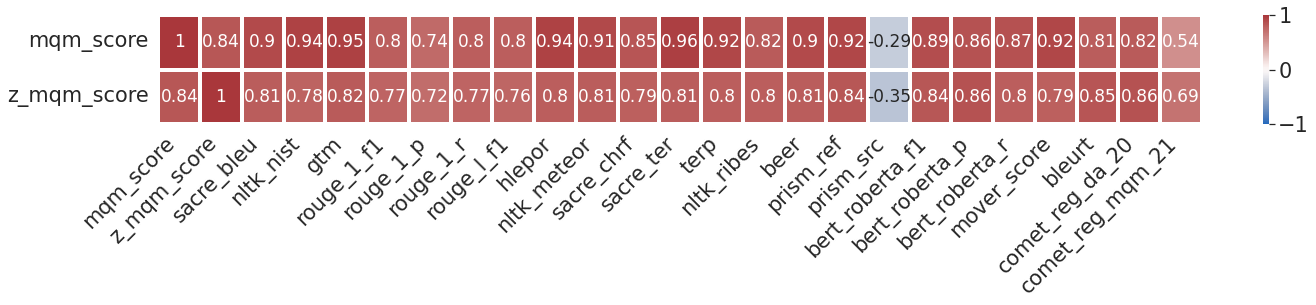

In [78]:
sns.set(rc={'figure.figsize':(22, 2)})
sns.set(font_scale=1.9)

m = mean_scores_df.corr().round(2)[:2]
m = m[columns]

fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 17},
                 cbar_kws={'fraction' : 0.1}, linewidth=4)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

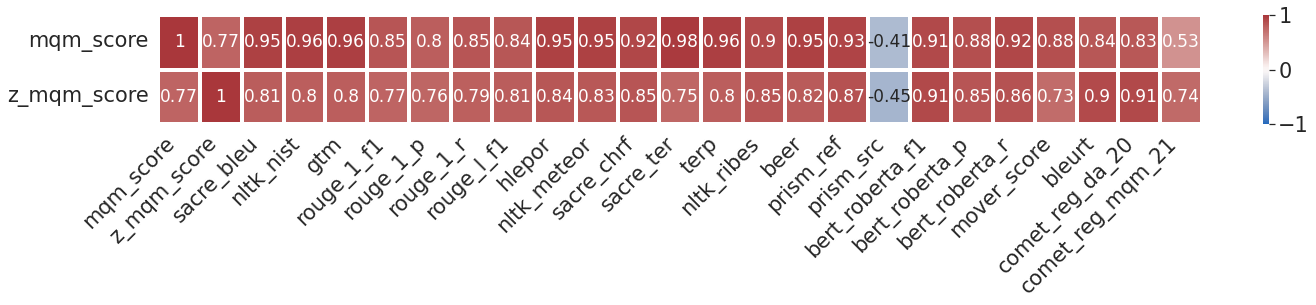

In [79]:
sns.set(rc={'figure.figsize':(22, 2)})
sns.set(font_scale=1.9)

m = mean_scores_df.corr(method='spearman').round(2)[:2]
m = m[columns]

fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 17},
                 cbar_kws={'fraction' : 0.1}, linewidth=4)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

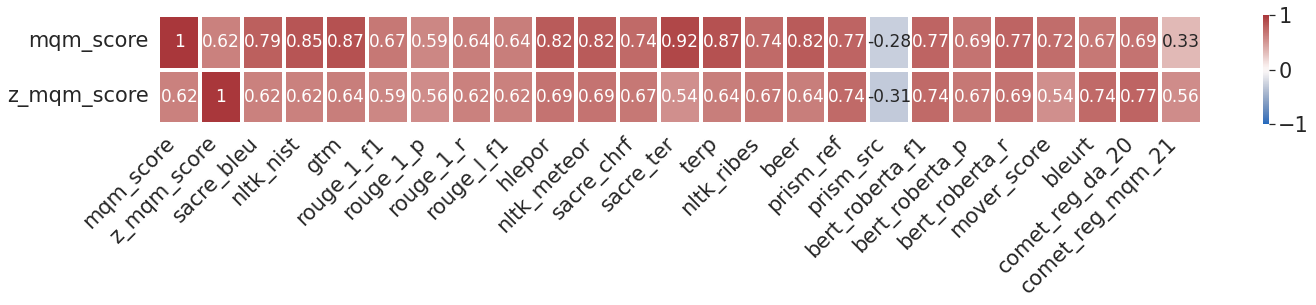

In [80]:
sns.set(rc={'figure.figsize':(22, 2)})
sns.set(font_scale=1.9)

m = mean_scores_df.corr(method='kendall').round(2)[:2]
m = m[columns]

fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 17},
                 cbar_kws={'fraction' : 0.1}, linewidth=4)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

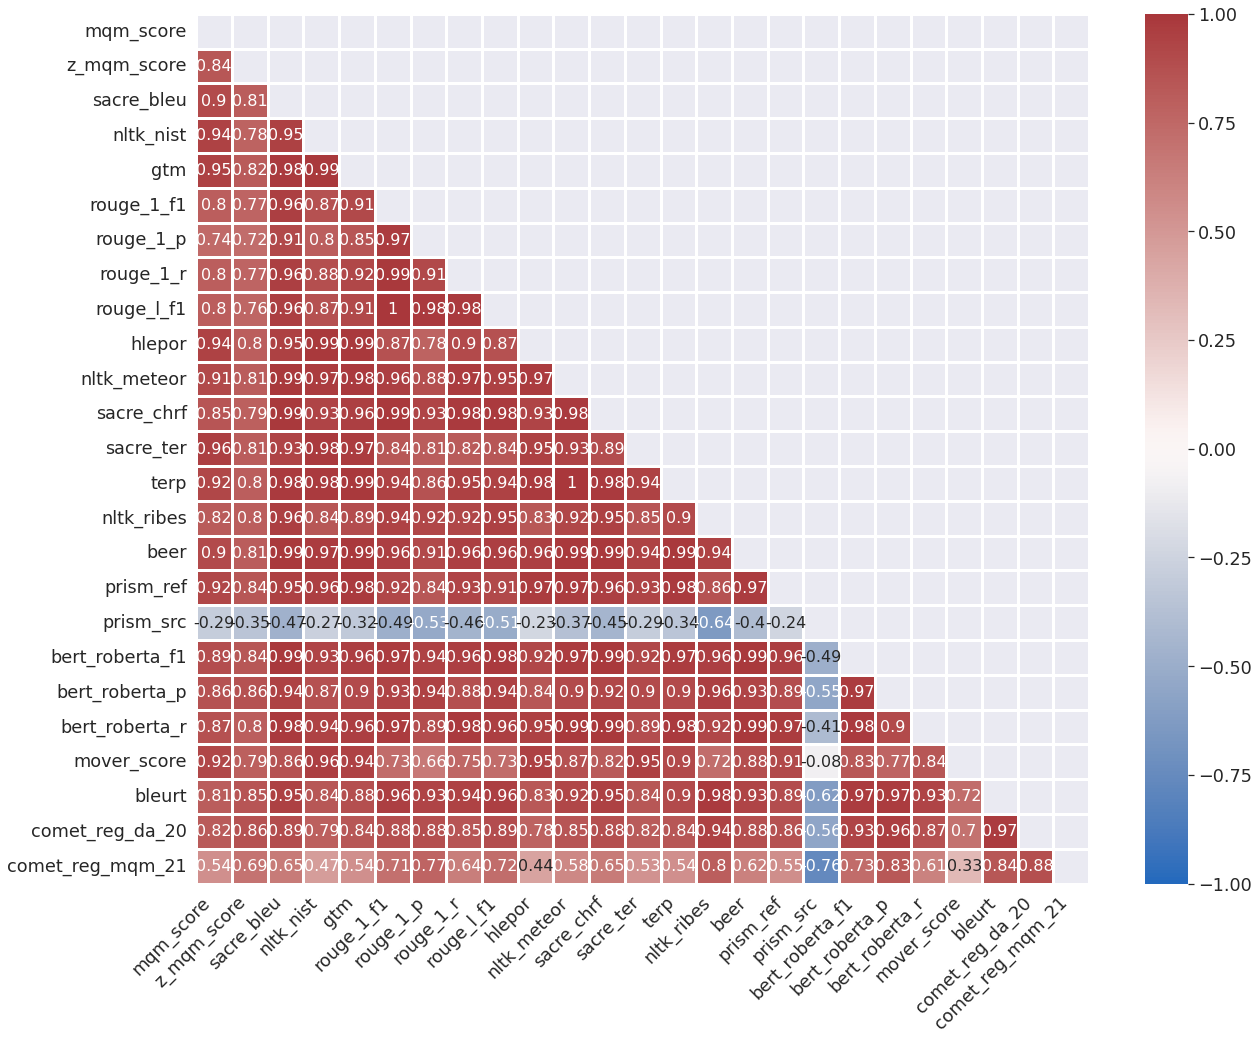

In [81]:
# Pearson

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20, 16)})
sns.set(font_scale=1.6)

matrix = mean_scores_df.corr().round(2)
matrix = matrix[columns]
mask = np.triu(np.ones_like(matrix, dtype=bool))
fig = sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, 
                  annot_kws={"size": 16}, linewidth=3)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

print()
plt.show()

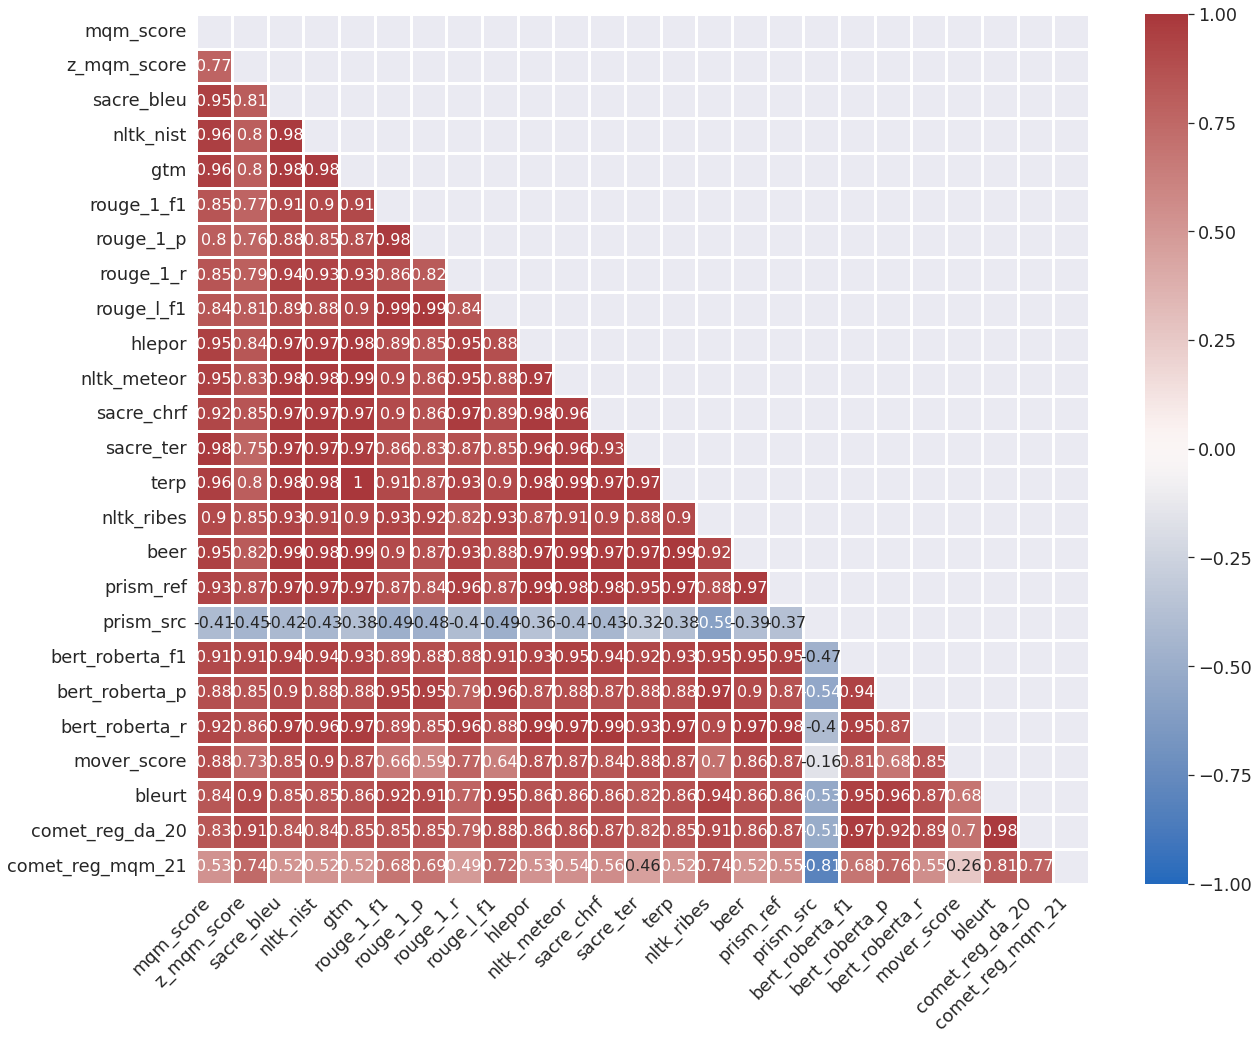

In [82]:
# Spearman

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20, 16)})
sns.set(font_scale=1.6)

matrix = mean_scores_df.corr(method='spearman').round(2)
matrix = matrix[columns]
mask = np.triu(np.ones_like(matrix, dtype=bool))
fig = sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, 
                  annot_kws={"size": 16}, linewidth=3)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

print()
plt.show()

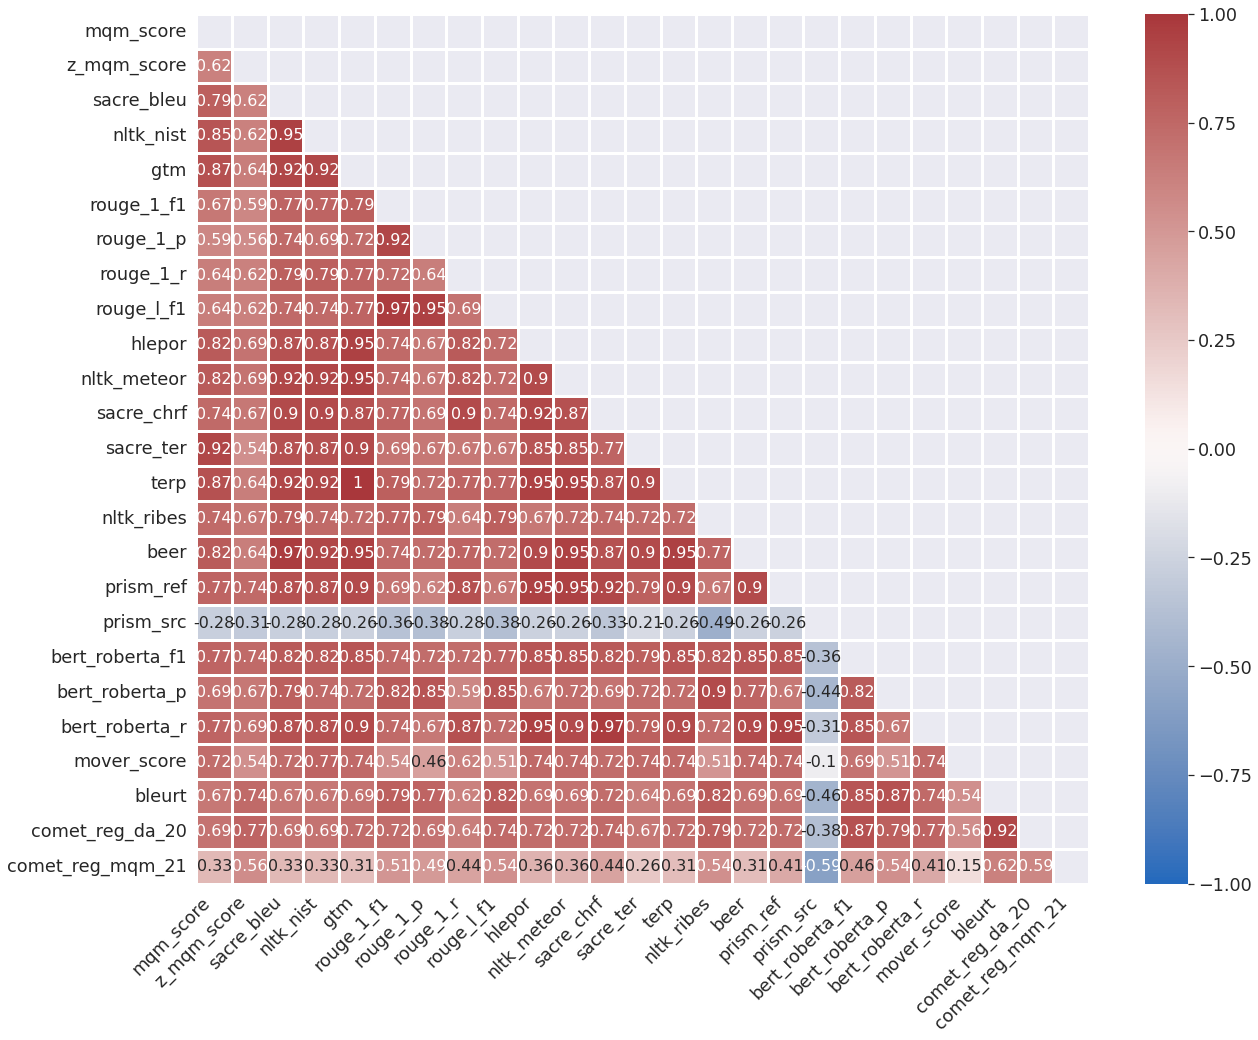

In [83]:
# Kendall

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20, 16)})
sns.set(font_scale=1.6)

matrix = mean_scores_df.corr(method='kendall').round(2)
matrix = matrix[columns]
mask = np.triu(np.ones_like(matrix, dtype=bool))
fig = sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, 
                  annot_kws={"size": 16}, linewidth=3)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

print()
plt.show()

---

## Correlation on segment level

In [84]:
unique_scores_df = unique_scores_df.drop(columns=['mt_system', 'seg_id'])

In [85]:
unique_scores_df = unique_scores_df[columns]

In [86]:
unique_scores_df.corr()

mqm_score  z_mqm_score  sacre_bleu  nltk_nist       gtm  \
mqm_score          1.000000     0.774487    0.096648   0.025813  0.129871   
z_mqm_score        0.774487     1.000000    0.128547   0.045244  0.156110   
sacre_bleu         0.096648     0.128547    1.000000   0.712213  0.846712   
nltk_nist          0.025813     0.045244    0.712213   1.000000  0.825989   
gtm                0.129871     0.156110    0.846712   0.825989  1.000000   
rouge_1_f1         0.090210     0.126065    0.791795   0.759726  0.927691   
rouge_1_p          0.081500     0.111753    0.753059   0.726744  0.892303   
rouge_1_r          0.092237     0.128648    0.770592   0.724224  0.897287   
rouge_l_f1         0.090019     0.127858    0.845422   0.706527  0.879646   
hlepor             0.115289     0.143204    0.812712   0.802163  0.953230   
nltk_meteor        0.118177     0.148249    0.868824   0.787159  0.950929   
sacre_chrf         0.116394     0.155622    0.825431   0.684765  0.840350   
sacre_ter          0.130595     0.157379    0.851201   0.773299  0.901249   
terp               0.131807     0.158323    0.865969   0.784883  0.963016   
nltk_ribes         0.104775     0.127010    0.688541   0.116053  0.440608   
beer               0.111694     0.147110    0.881646   0.799865  0.935256   
prism_ref          0.095416     0.129791    0.436093   0.373527  0.476578   
prism_src         -0.004852     0.008303    0.089124   0.062635  0.094934   
bert_roberta_f1    0.176238     0.229690    0.746118   0.643510  0.792761   
bert_roberta_p     0.169161     0.223686    0.718668   0.629376  0.767295   
bert_roberta_r     0.169546     0.217451    0.715761   0.606812  0.756687   
mover_score        0.164153     0.183428    0.374433   0.233248  0.385895   
bleurt             0.279566     0.350788    0.546114   0.314654  0.562490   
comet_reg_da_20    0.265730     0.340881    0.456350   0.340541  0.521411   
comet_reg_mqm_21   0.267561     0.324410    0.246740  -0.111979  0.267261   

                  rouge_1_f1  rouge_1_p  rouge_1_r  rouge_l_f1    hlepor  ...  \
mqm_score           0.090210   0.081500   0.092237    0.090019  0.115289  ...   
z_mqm_score         0.126065   0.111753   0.128648    0.127858  0.143204  ...   
sacre_bleu          0.791795   0.753059   0.770592    0.845422  0.812712  ...   
nltk_nist           0.759726   0.726744   0.724224    0.706527  0.802163  ...   
gtm                 0.927691   0.892303   0.897287    0.879646  0.953230  ...   
rouge_1_f1          1.000000   0.961812   0.968236    0.930407  0.914046  ...   
rouge_1_p           0.961812   1.000000   0.865641    0.893306  0.824240  ...   
rouge_1_r           0.968236   0.865641   1.000000    0.901889  0.928816  ...   
rouge_l_f1          0.930407   0.893306   0.901889    1.000000  0.872443  ...   
hlepor              0.914046   0.824240   0.928816    0.872443  1.000000  ...   
nltk_meteor         0.911978   0.840471   0.916019    0.895691  0.943150  ...   
sacre_chrf          0.867955   0.792647   0.878165    0.852485  0.841756  ...   
sacre_ter           0.808126   0.809040   0.741234    0.848056  0.840580  ...   
terp                0.918330   0.847647   0.920205    0.904287  0.950580  ...   
nltk_ribes          0.414030   0.396764   0.406730    0.521481  0.408208  ...   
beer                0.925365   0.874402   0.905268    0.906210  0.914723  ...   
prism_ref           0.459001   0.425418   0.454607    0.479648  0.498187  ...   
prism_src           0.090387   0.079269   0.091368    0.111972  0.117280  ...   
bert_roberta_f1     0.775255   0.721350   0.765036    0.806002  0.797956  ...   
bert_roberta_p      0.749664   0.740549   0.700601    0.782765  0.736142  ...   
bert_roberta_r      0.740646   0.647113   0.769486    0.766899  0.796689  ...   
mover_score         0.335745   0.308399   0.333479    0.354678  0.366868  ...   
bleurt              0.579482   0.536666   0.575219    0.596235  0.572075  ...   
comet_reg_da_20     0.526578   0.486314   0.520319    0.539755  0.52982

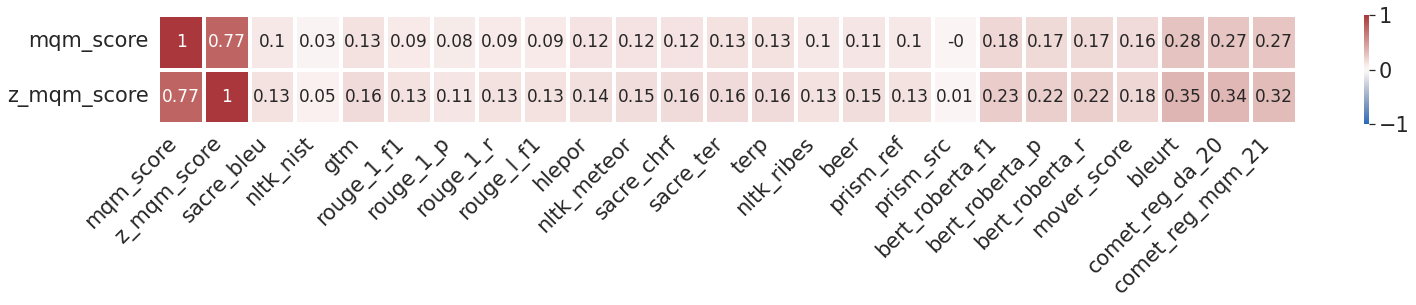

In [88]:
sns.set(rc={'figure.figsize':(24, 2)})
sns.set(font_scale=1.9)

m = unique_scores_df.corr().round(2)[:2]
m = m[columns]

fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 17},
                 cbar_kws={'fraction' : 0.1}, linewidth=4)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

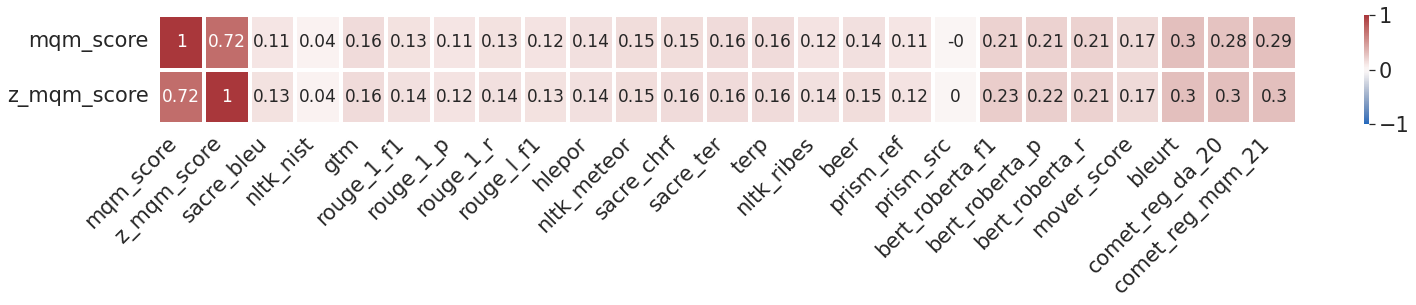

In [91]:
sns.set(rc={'figure.figsize':(24, 2)})
sns.set(font_scale=1.9)

m = unique_scores_df.corr(method='spearman').round(2)[:2]
m = m[columns]

fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 17},
                 cbar_kws={'fraction' : 0.1}, linewidth=4)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

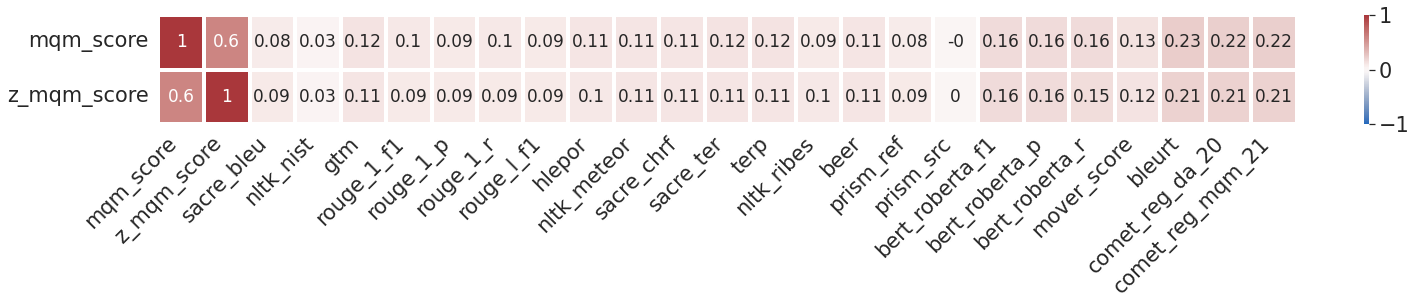

In [92]:
sns.set(rc={'figure.figsize':(24, 2)})
sns.set(font_scale=1.9)

m = unique_scores_df.corr(method='kendall').round(2)[:2]
m = m[columns]

fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 17},
                 cbar_kws={'fraction' : 0.1}, linewidth=4)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

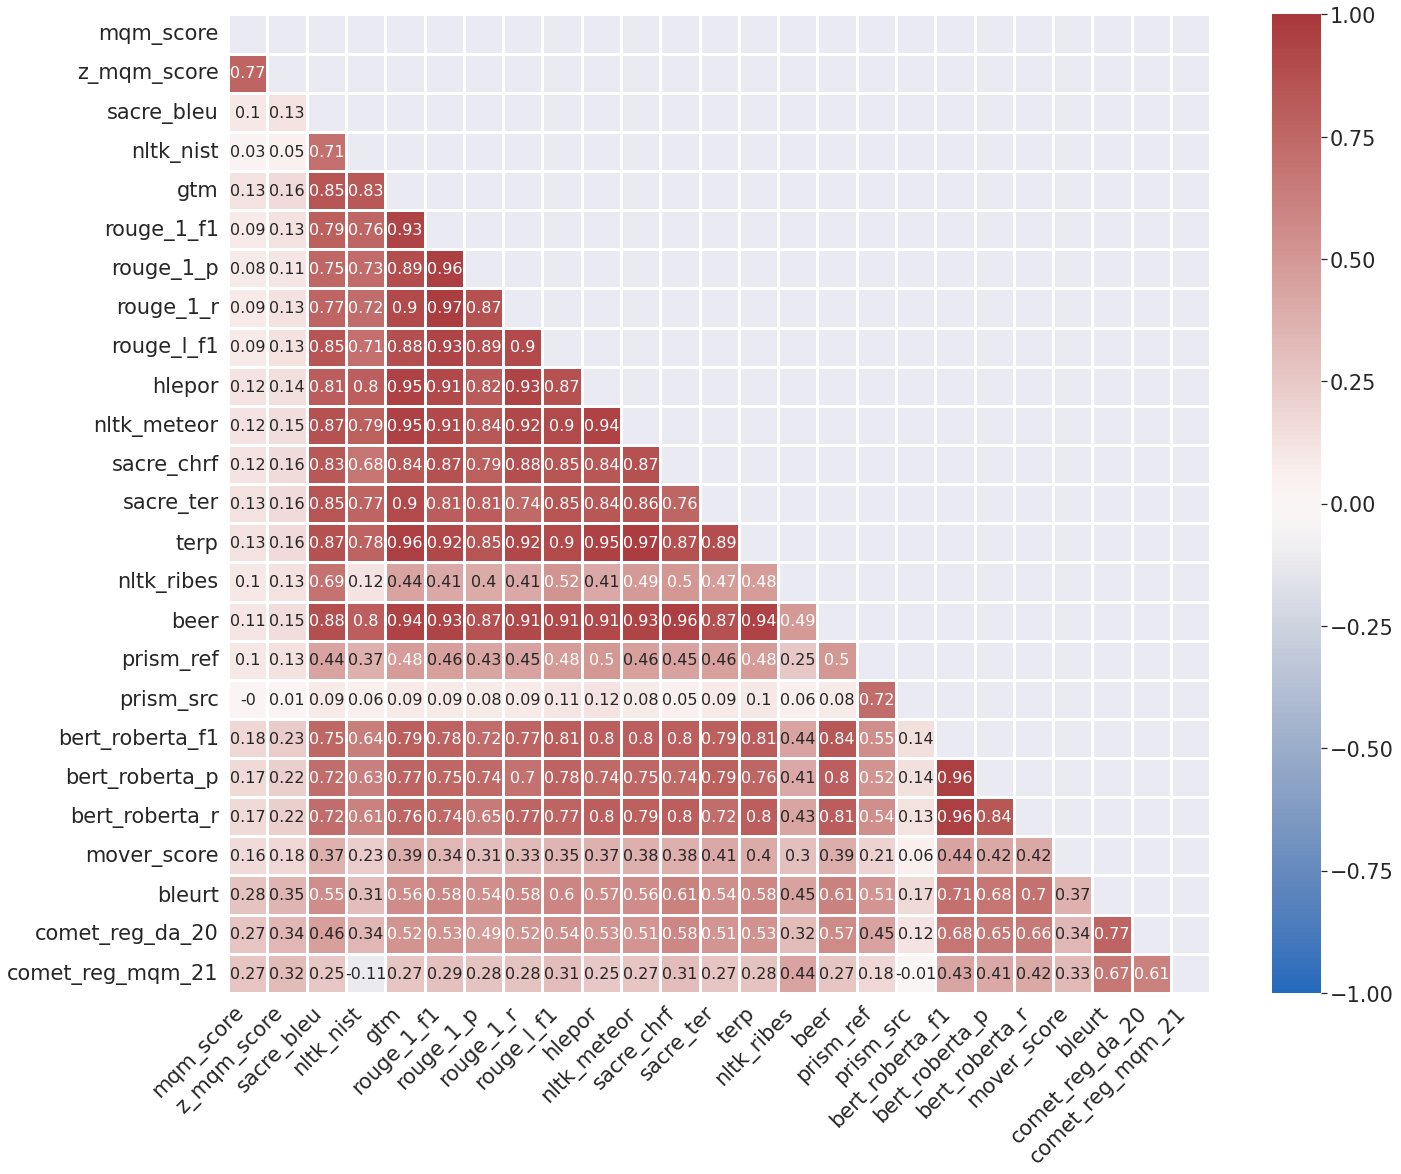

In [102]:
# Pearson

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(22, 18)})
sns.set(font_scale=1.9)

mask = np.triu(np.ones_like(matrix, dtype=bool))
matrix = unique_scores_df.corr().round(2)
matrix = matrix[columns]
fig = sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, 
                  annot_kws={"size": 16}, linewidth=3)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

print()
plt.show()

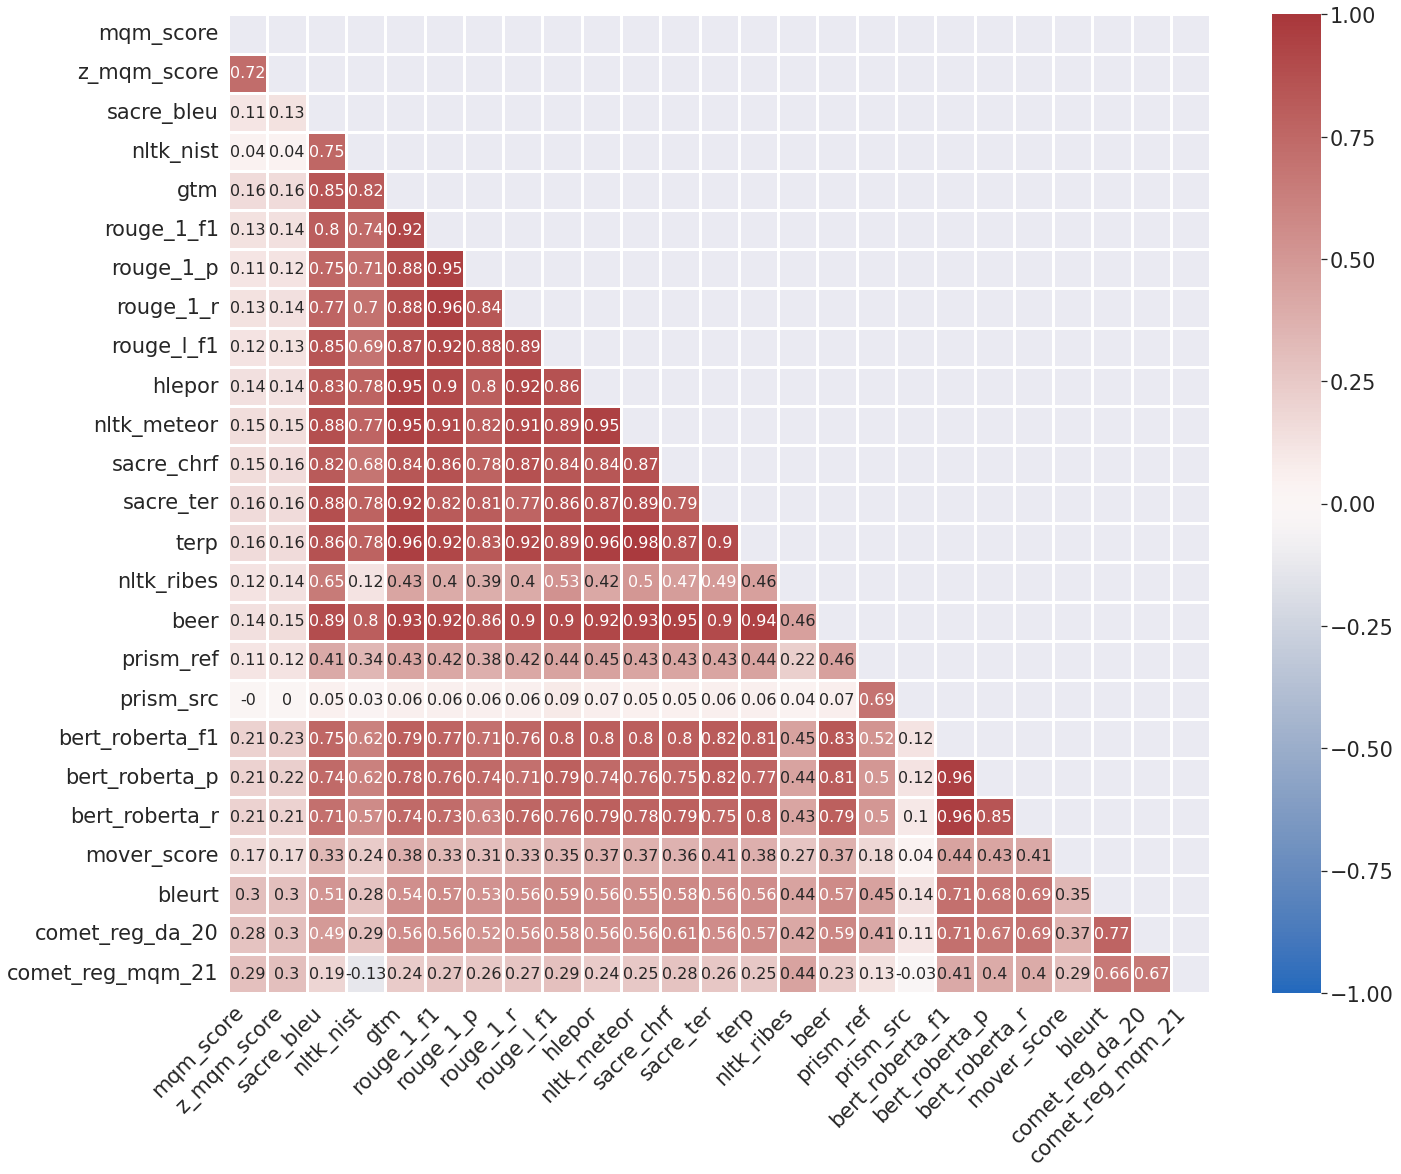

In [103]:
# Spearman

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(22, 18)})
sns.set(font_scale=1.9)

mask = np.triu(np.ones_like(matrix, dtype=bool))
matrix = unique_scores_df.corr(method='spearman').round(2)
matrix = matrix[columns]
fig = sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, 
                  annot_kws={"size": 16}, linewidth=3)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

print()
plt.show()

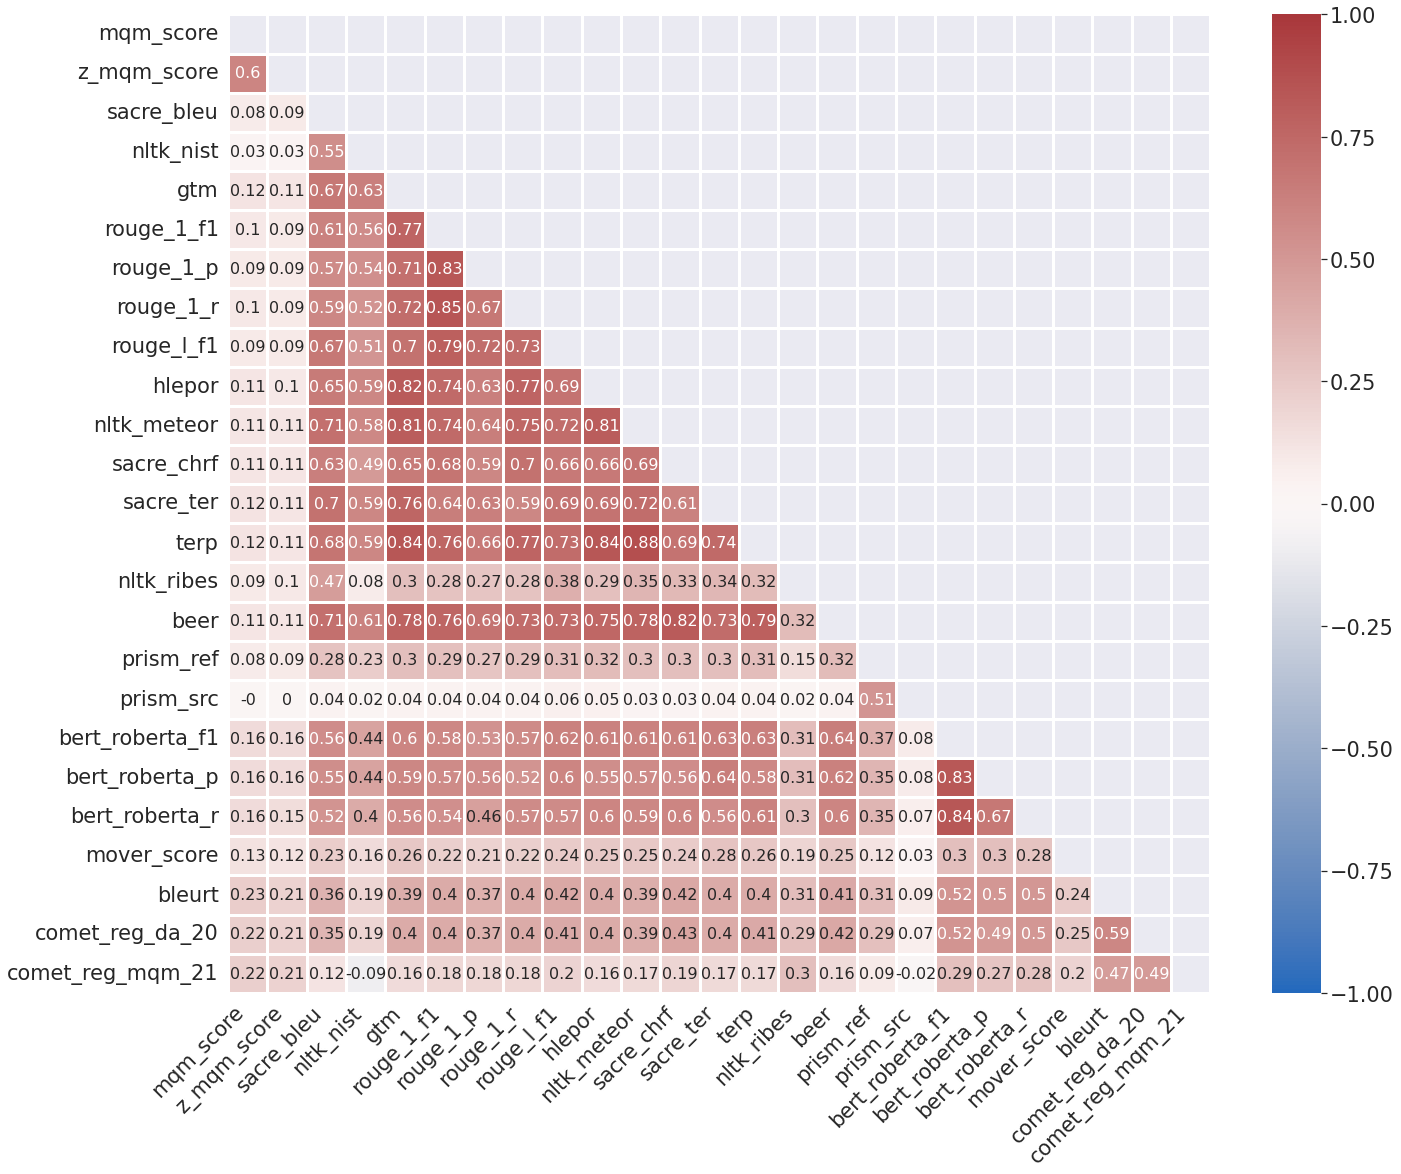

In [104]:
# Kendall

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(22, 18)})
sns.set(font_scale=1.9)

mask = np.triu(np.ones_like(matrix, dtype=bool))
matrix = unique_scores_df.corr(method='kendall').round(2)
matrix = matrix[columns]
fig = sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask, 
                  annot_kws={"size": 16}, linewidth=3)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

print()
plt.show()

In [377]:
unique_scores_df.corr()

mqm_score  z_mqm_score  sacre_bleu  nltk_nist       gtm  \
mqm_score         1.000000     0.774487    0.096648   0.002907  0.129871   
z_mqm_score       0.774487     1.000000    0.128547   0.025142  0.156110   
sacre_bleu        0.096648     0.128547    1.000000   0.694549  0.846712   
nltk_nist         0.002907     0.025142    0.694549   1.000000  0.788493   
gtm               0.129871     0.156110    0.846712   0.788493  1.000000   
rouge_1_f1        0.090210     0.126065    0.791795   0.752880  0.927691   
rouge_1_p         0.081500     0.111753    0.753059   0.715649  0.892303   
rouge_1_r         0.092237     0.128648    0.770592   0.721021  0.897287   
hlepor            0.115289     0.143204    0.812712   0.798846  0.953230   
nltk_meteor       0.121798     0.149876    0.858894   0.766468  0.940674   
sacre_chrf        0.116394     0.155622    0.825431   0.668453  0.840350   
sacre_ter         0.130595     0.157379    0.851201   0.741481  0.901249   
terp              0.131807     0.158323    0.865969   0.756188  0.963016   
nltk_ribes        0.104775     0.127010    0.688541   0.092781  0.440608   
beer              0.111694     0.147110    0.881646   0.778103  0.935256   
prism_ref         0.095416     0.129791    0.436093   0.396157  0.476578   
prism_src        -0.004852     0.008303    0.089124   0.085352  0.094934   
bert_roberta_f1   0.176238     0.229690    0.746118   0.639040  0.792761   
bert_roberta_p    0.169161     0.223686    0.718668   0.626920  0.767295   
bert_roberta_r    0.169546     0.217451    0.715761   0.599940  0.756687   
mover_score       0.164153     0.183428    0.374433   0.192889  0.385895   
bleurt            0.279566     0.350788    0.546114   0.305271  0.562490   

                 rouge_1_f1  rouge_1_p  rouge_1_r    hlepor  nltk_meteor  ...  \
mqm_score          0.090210   0.081500   0.092237  0.115289     0.121798  ...   
z_mqm_score        0.126065   0.111753   0.128648  0.143204     0.149876  ...   
sacre_bleu         0.791795   0.753059   0.770592  0.812712     0.858894  ...   
nltk_nist          0.752880   0.715649   0.721021  0.798846     0.766468  ...   
gtm                0.927691   0.892303   0.897287  0.953230     0.940674  ...   
rouge_1_f1         1.000000   0.961812   0.968236  0.914046     0.915808  ...   
rouge_1_p          0.961812   1.000000   0.865641  0.824240     0.841874  ...   
rouge_1_r          0.968236   0.865641   1.000000  0.928816     0.921605  ...   
hlepor             0.914046   0.824240   0.928816  1.000000     0.955745  ...   
nltk_meteor        0.915808   0.841874   0.921605  0.955745     1.000000  ...   
sacre_chrf         0.867955   0.792647   0.878165  0.841756     0.870478  ...   
sacre_ter          0.808126   0.809040   0.741234  0.840580     0.854829  ...   
terp               0.918330   0.847647   0.920205  0.950580     0.964705  ...   
nltk_ribes         0.414030   0.396764   0.406730  0.408208     0.481294  ...   
beer               0.925365   0.874402   0.905268  0.914723     0.923584  ...   
prism_ref          0.459001   0.425418   0.454607  0.498187     0.465591  ...   
prism_src          0.090387   0.079269   0.091368  0.117280     0.077225  ...   
bert_roberta_f1    0.775255   0.721350   0.765036  0.797956     0.803263  ...   
bert_roberta_p     0.749664   0.740549   0.700601  0.736142     0.751705  ...   
bert_roberta_r     0.740646   0.647113   0.769486  0.796689     0.791770  ...   
mover_score        0.335745   0.308399   0.333479  0.366868     0.374352  ...   
bleurt             0.579482   0.536666   0.575219  0.572075     0.572111  ...   

                     terp  nltk_ribes      beer  prism_ref  prism_src  \
mqm_score        0.131807    0.104775  0.111694   0.095416  -0.004852   
z_mqm_score      0.158323    0.127010  0.147110   0.129791   0.008303   
sacre_bleu       0.865969    0.688541  0.881646   0.436093   0.089124   
nltk_nist        0.756188    0.092781  0.778103   0.396157   0.085352   
gtm              0.963016    0.440608  

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='z_mqm_score', ylabel='terp'>

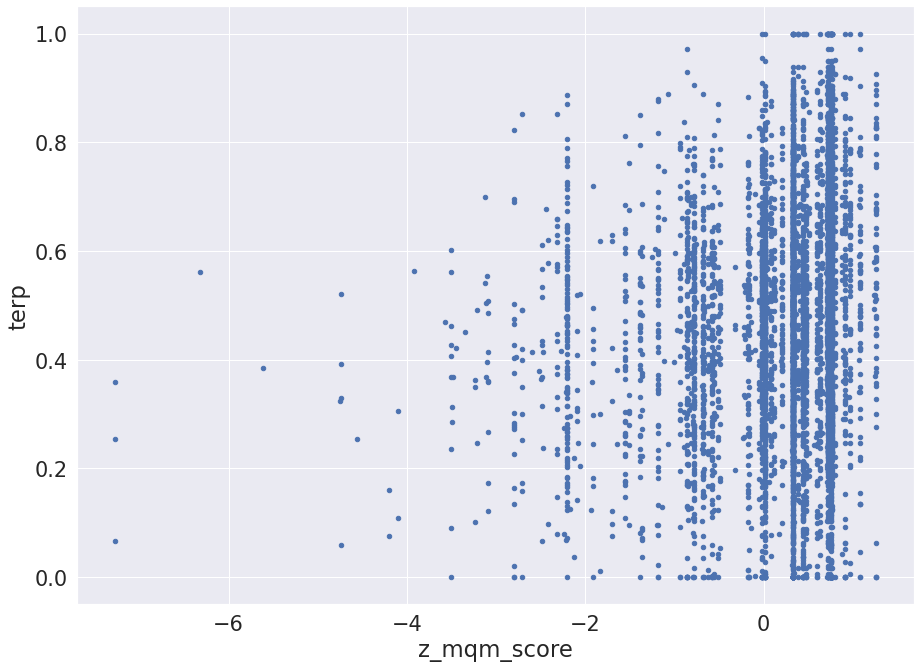

In [385]:
unique_scores_df.plot.scatter(y='terp', x='z_mqm_score', figsize=(15,11))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='z_mqm_score', ylabel='sacre_chrf'>

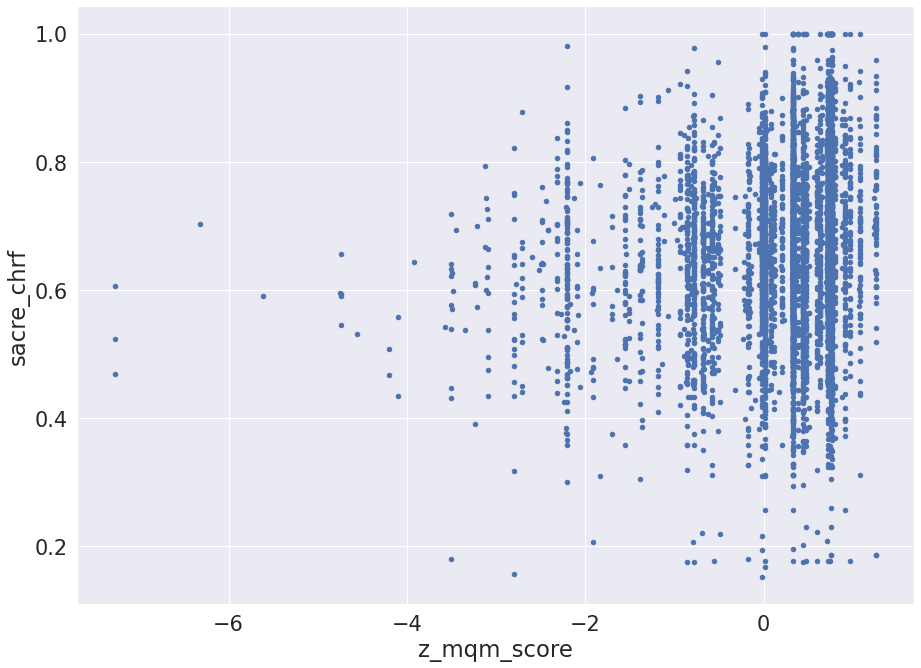

In [382]:
unique_scores_df.plot.scatter(y='sacre_chrf', x='z_mqm_score', figsize=(15,11))

---
---

# Compute correlation for every type of error

In [223]:
categories = full_df.category.values

array(['Accuracy/Mistranslation', 'Accuracy/Untranslated',
       'Style/Awkward', 'Fluency/Punctuation', 'Other',
       'Accuracy/Omission', 'No-error', 'Terminology/Inappropriate',
       'Fluency/Grammar', 'Fluency/Inconsistency', 'Fluency/Spelling',
       'Fluency/Display', 'Fluency/Register', 'Accuracy/Addition',
       'Source_error', 'Terminology/Inconsistent',
       'Locale_convention/Currency', 'Locale_convention/Date',
       'Locale_convention/Time'], dtype=object)

In [105]:
categories = full_df.category.values

def get_sc(c):
    sc = c.split('/')
    return sc[0]
        
super_categories = full_df.category.apply(lambda c: get_sc(c)).values
super_categories

array(['Accuracy', 'Accuracy', 'Style', ..., 'No-error', 'No-error',
       'Terminology'], dtype=object)

In [106]:
metric_scores['error_type'] = super_categories
metric_scores

mqm_score  z_mqm_score      mt_system  sacre_bleu  sacre_chrf  \
0          -5.0    -0.013807    Facebook-AI    0.310978    0.485126   
1          -5.0    -0.858404      HuaweiTSC    0.166685    0.454055   
2          -6.0    -1.182732           Nemo    0.092059    0.408957   
3          -6.0    -1.182732           Nemo    0.092059    0.408957   
4          -5.0    -0.561254       Online-W    0.128462    0.486589   
...         ...          ...            ...         ...         ...   
8345       -2.0     0.342346  metricsystem1    0.299924    0.640811   
8346       -5.0     0.080083  metricsystem2    0.269947    0.538037   
8347       -0.0     0.709702  metricsystem3    0.299924    0.640811   
8348       -0.0     0.326909  metricsystem4    0.299924    0.640811   
8349       -5.0     0.080083  metricsystem5    0.201202    0.511776   

      sacre_ter  nltk_meteor  nltk_nist  nltk_ribes    hlepor  ...  rouge_1_p  \
0      0.481481     0.559780   2.276816    0.300881  0.586640  ...    0.68750   
1      0.444444     0.511368   2.114186    0.133387  0.553841  ...    0.68750   
2      0.296296     0.314061   1.338224    0.132567  0.409013  ...    0.44444   
3      0.296296     0.314061   1.338224    0.132567  0.409013  ...    0.44444   
4      0.407407     0.471792   1.901719    0.111794  0.549411  ...    0.66667   
...         ...          ...        ...         ...       ...  ...        ...   
8345   0.615385     0.581395   2.880997    0.152584  0.708601  ...    0.69565   
8346   0.500000     0.508721   2.499732    0.194703  0.581850  ...    0.52174   
8347   0.615385     0.581395   2.880997    0.152584  0.708601  ...    0.69565   
8348   0.615385     0.581395   2.880997    0.152584  0.708601  ...    0.69565   
8349   0.423077     0.488226   2.370624    0.121437  0.618557  ...    0.50000   

      rouge_1_r  rouge_l_f1       gtm      terp  mover_score  comet_reg_da_20  \
0       0.45833     0.55000  0.595745  0.337017     0.935223        -0.759673   
1       0.45833     0.55000  0.553191  0.279367     0.926463        -0.765728   
2       0.33333     0.38095  0.391304  0.000000     0.911528        -0.850904   
3       0.33333     0.38095  0.391304  0.000000     0.911528        -0.850904   
4       0.50000     0.52381  0.565217  0.205701     0.922788        -0.931326   
...         ...         ...       ...       ...          ...              ...   
8345    0.66667     0.68085  0.640000  0.411298     0.941740         0.715877   
8346    0.50000     0.51064  0.560000  0.286593     0.935292        -0.314926   
8347    0.66667     0.68085  0.640000  0.411298     0.941740         0.715831   
8348    0.66667     0.68085  0.640000  0.411298     0.941740         0.715831   
8349    0.54167     0.48000  0.538462  0.250034     0.940829         0.434510   

      comet_reg_mqm_21  seg_id   error_type  
0             0.016829       1     Accuracy  
1             0.016492       1     Accuracy  
2             0.015186       1        Style  
3             0.015186       1     Accuracy  
4             0.016496       1     Accuracy  
...                ...     ...          ...  
8345          0.036771    1002        Style  
8346          0.025257    1002        Style  
8347          0.036779    1002     No-error  
8348          0.036779    1002     No-error  
8349          0.031601    1002  Terminology  

[8350 rows x 28 columns]

In [107]:
error_types = metric_scores.error_type.unique()

Size of dataset: 898 samples


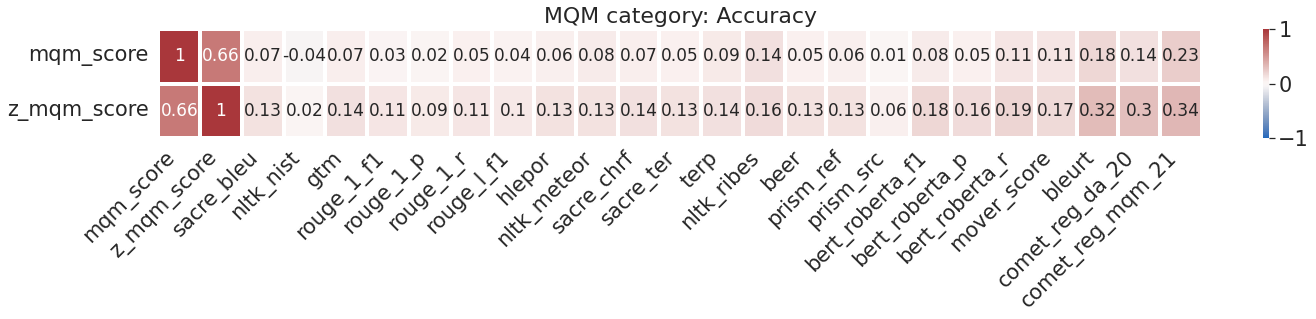

Size of dataset: 1542 samples


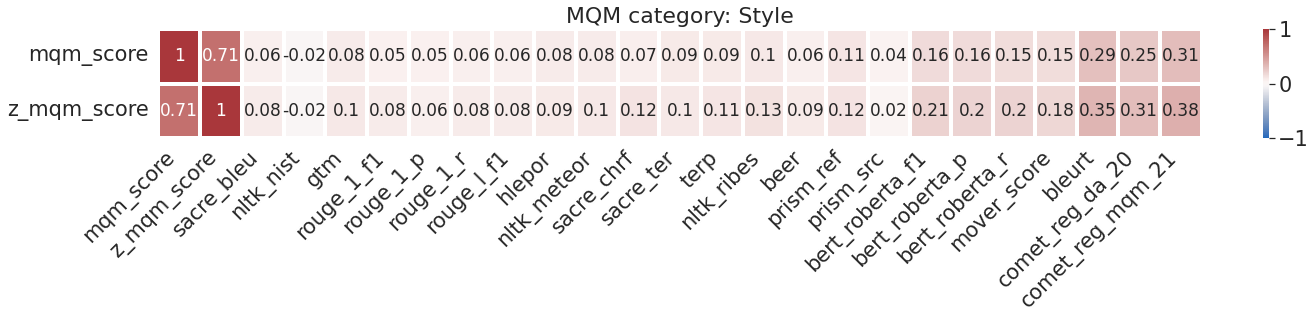

Size of dataset: 926 samples


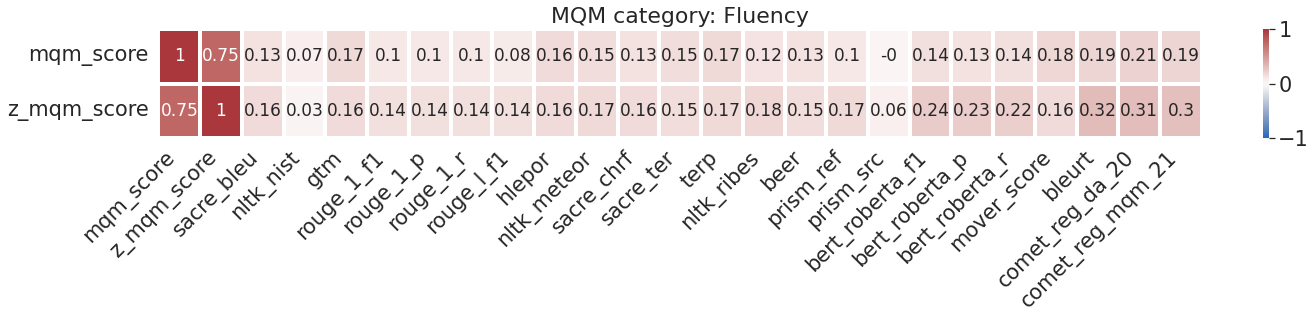

Size of dataset: 85 samples


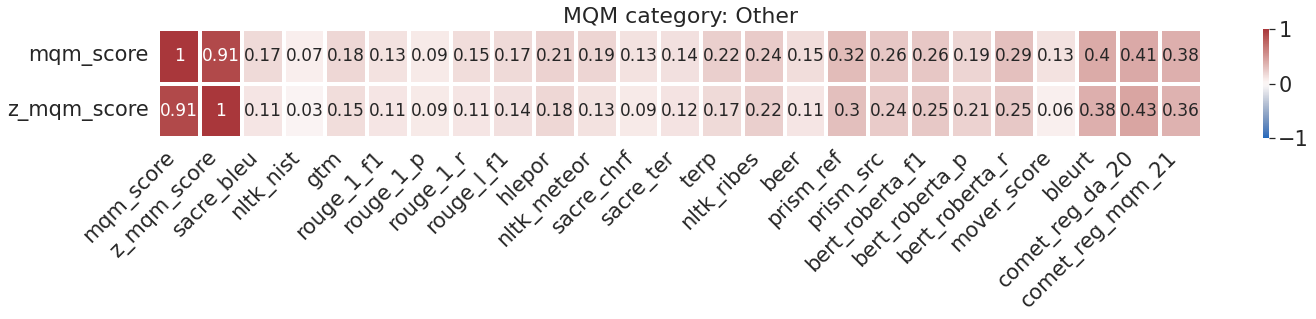

Size of dataset: 3863 samples


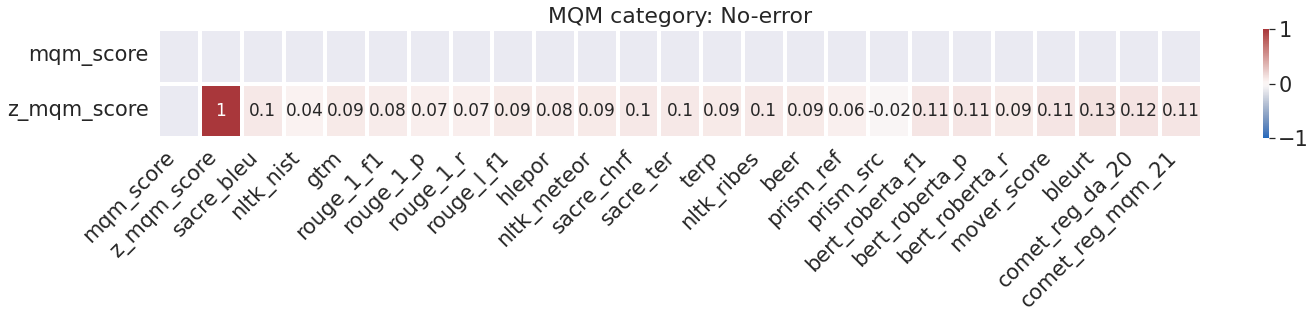

Size of dataset: 242 samples


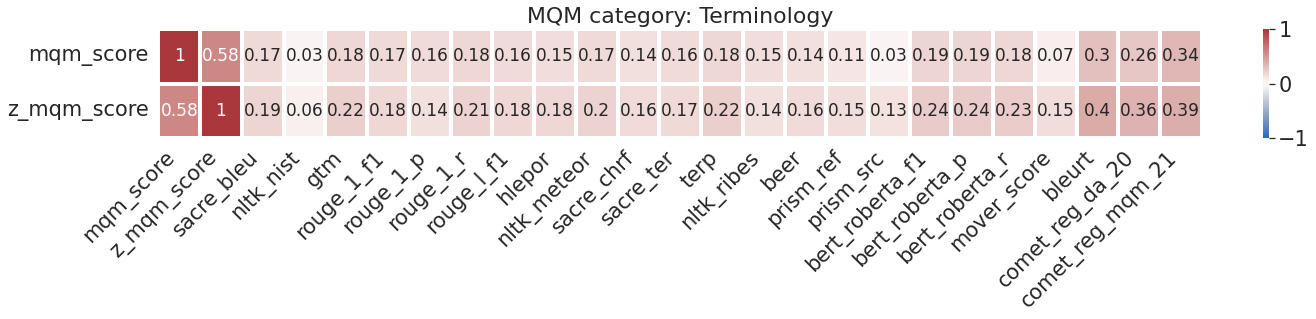

Size of dataset: 7 samples


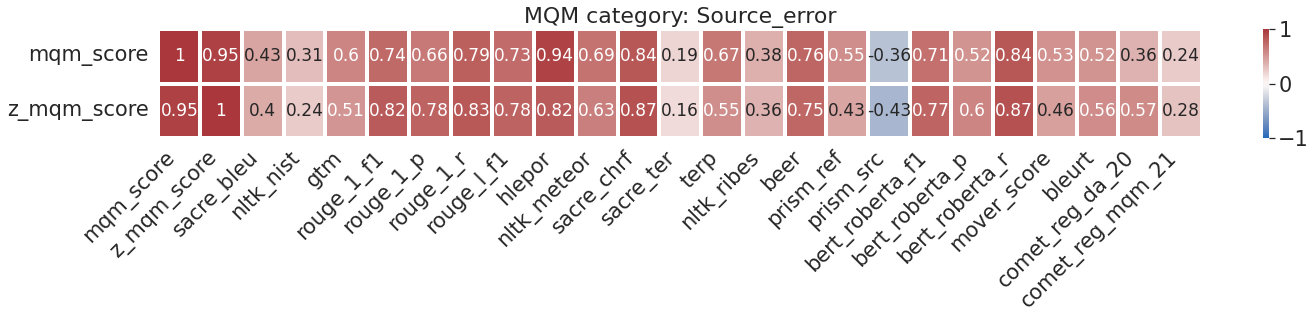

Size of dataset: 13 samples


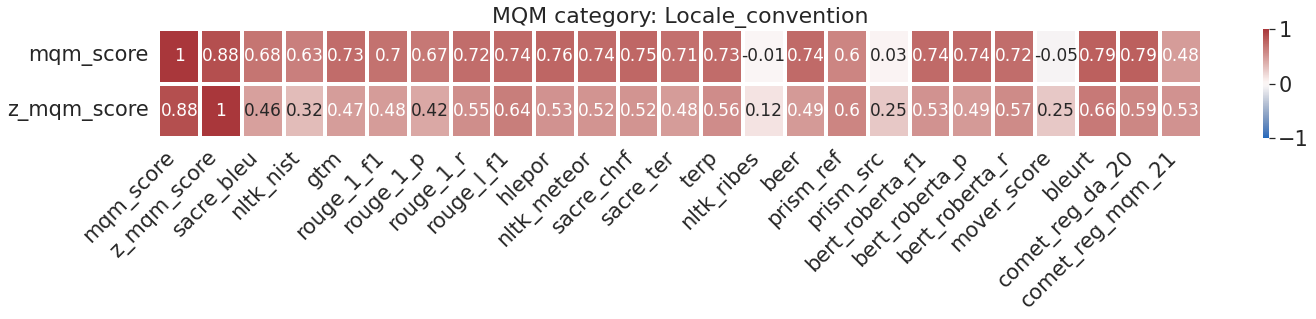

In [109]:
for err in error_types:
    tmp_df = metric_scores[metric_scores.error_type == err].copy()
    tmp_df = tmp_df.drop_duplicates(subset=['seg_id', 'mt_system'])
    tmp_df = tmp_df.drop(columns=['seg_id', 'mt_system'])
    tmp_df = tmp_df[columns]
    print(f'Size of dataset: {len(tmp_df)} samples')
    sns.set(rc={'figure.figsize':(22, 2)})
    sns.set(font_scale=1.9)

    m = tmp_df.corr(method='pearson').round(2)[:2]

    fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 17},
                     cbar_kws={'fraction' : 0.1}, linewidth=4)

    fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
    
    plt.title(f'MQM category: {err}', fontsize = 22)
    plt.show()

### Correlation on data with "No-error" and any error label

In [229]:
# no_err_df = metric_scores[metric_scores['error_type'] == 'No-error'].copy()
# df_with_error = metric_scores[metric_scores['error_type'] != 'No-error'].copy()

Size of dataset: 2988 samples


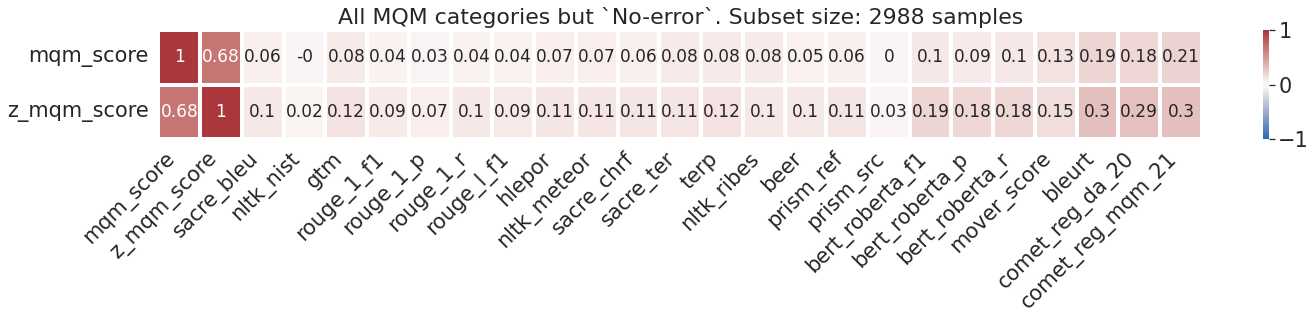

In [113]:
df_with_error = metric_scores[metric_scores['error_type'] != 'No-error'].copy()
df_with_error = df_with_error.drop_duplicates(subset=['seg_id', 'mt_system'])
df_with_error = df_with_error.drop(columns=['seg_id', 'mt_system'])
df_with_error = df_with_error[columns]
print(f'Size of dataset: {len(df_with_error)} samples')
sns.set(rc={'figure.figsize':(22, 2)})
sns.set(font_scale=1.9)

m = df_with_error.corr(method='pearson').round(2)[:2]

fig = sns.heatmap(m, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', annot_kws={"size": 17},
                 cbar_kws={'fraction' : 0.1}, linewidth=4)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title(f'All MQM categories but `No-error`. Subset size: {len(df_with_error)} samples', fontsize = 22)
plt.show()

## Analyse ref-C and ref-D

In [257]:
data_folder = 'wmt21'
news_refD_path = os.path.join(data_folder, 'reference', 'newstest2021.en-de.ref.ref-D.de')
with open(news_refD_path, 'r') as f:
    ref_D = f.readlines()
ref_D = [s[:-1] for s in ref_D]
ref_D

['Paar bekommt beim Mittagessen in einem Hundepark Pfefferspray ins Gesicht gesprüht, weil es keinen Mundschutz trug (VIDEO) - RT USA Nachrichten',
 'Es gibt "Mask-shaming" und dann gibt es regelrechten Angriff.',
 'Ein Paar aus Kalifornien, das mit seinem Hundewelpen in einem Hundepark zu Mittag aß, erlebte das zweite, als ihm eine aufgebrachte Frau Pfefferspray ins Gesicht sprühte, weil es keinen Mundschutz trug - beim Essen.',
 "Ash O'Brien und ihr Ehemann Jarett Kelley erzählen, dass sie am Donnerstag im Dusty Rhodes- Hundepark in San Diego mit ihrem drei Monate alten Hund im Schlepptau dabei waren, eine Kleinigkeit zu essen.",
 'Das Paar hatte seinen Mundschutz abgenommen, um zu essen, als sich ihm "irgendeine alte Frau" näherte und es "Idioten" nannte, weil es keinen Mundschutz trug, obwohl "man nicht gleichzeitig essen und einen Mundschutz tragen kann".',
 "O'Brien sagte der Frau, sie solle den Park verlassen und aufhören, sie zu belästigen, woraufhin die Frau eine Dose Pfeffers

In [280]:
ref_D = [custom_preprocess(s, True, False, True) for s in ref_D]

In [281]:
ref_D_df = pd.DataFrame({'ref-D': ref_D, 'seg_id': list(range(1, len(ref_D)+1))})
ref_D_df

ref-D  seg_id
0     paar bekommt beim mittagessen in einem hundepa...       1
1     es gibt mask shaming und dann gibt es regelrec...       2
2     ein paar aus kalifornien das mit seinem hundew...       3
3     ash obrien und ihr ehemann jarett kelley erzäh...       4
4     das paar hatte seinen mundschutz abgenommen um...       5
...                                                 ...     ...
997   die labour abgeordnete jess phillips sagte am ...     998
998   sein parlamentskollege neil coyle fügte hinzu ...     999
999   john mann der unabhängige berater der regierun...    1000
1000  mittlerweile hat die kampagne gegen antisemiti...    1001
1001  wiley bekannt als godfather of grime dessen bü...    1002

[1002 rows x 2 columns]

In [294]:
ref_analysis_df = full_df[['system_name', 'seg_id']].copy()

In [271]:
full_df.reference.values[-1]

'Wiley, bekannt als „Godfather of Grime“, dessen echter Name Richard Cowie lautet, erhielt 2018 einen MBE-Orden für Dienste für die Musik.'

In [295]:
ref_analysis_df['ref-C'] = [custom_preprocess(s, True, False, True) for s in full_df.reference.values]

In [296]:
ref_analysis_df['mt_output'] = [custom_preprocess(s, True, False, True) for s in full_df.mt_output.values]

In [298]:
ref_analysis_df = ref_analysis_df.join(ref_D_df.set_index('seg_id'), on='seg_id')
ref_analysis_df = ref_analysis_df.drop(columns=['system_name'])

In [299]:
ref_analysis_df

seg_id                                              ref-C  \
0          1  angriff mit pfefferspray auf ein paar in einem...   
1          1  angriff mit pfefferspray auf ein paar in einem...   
2          1  angriff mit pfefferspray auf ein paar in einem...   
3          1  angriff mit pfefferspray auf ein paar in einem...   
4          1  angriff mit pfefferspray auf ein paar in einem...   
...      ...                                                ...   
8345    1002  wiley  bekannt als  godfather of grime   desse...   
8346    1002  wiley  bekannt als  godfather of grime   desse...   
8347    1002  wiley  bekannt als  godfather of grime   desse...   
8348    1002  wiley  bekannt als  godfather of grime   desse...   
8349    1002  wiley  bekannt als  godfather of grime   desse...   

                                              mt_output  \
0     paar maced im kalifornischen hundepark  weil e...   
1     paar maced im kalifornischen hundepark  weil e...   
2     paar maced im kalifornischen hundepark für das...   
3     paar maced im kalifornischen hundepark für das...   
4     paar maced in kalifornien hundepark für nicht ...   
...                                                 ...   
8345  wiley  bekannt als godfather of grime und mit ...   
8346  wiley  bekannt als der pate des schmutzes und ...   
8347  wiley  bekannt als godfather of grime und mit ...   
8348  wiley  bekannt als godfather of grime und mit ...   
8349  wiley  der als pate von grime bekannt ist und ...   

                                                  ref-D  
0     paar bekommt beim mittagessen in einem hundepa...  
1     paar bekommt beim mittagessen in einem hundepa...  
2     paar bekommt beim mittagessen in einem hundepa...  
3     paar bekommt beim mittagessen in einem hundepa...  
4     paar bekommt beim mittagessen in einem hundepa...  
...                                                 ...  
8345  wiley bekannt als godfather of grime dessen bü...  
8346  wiley bekannt als godfather of grime dessen bü...  
8347  wiley bekannt als godfather of grime dessen bü...  
8348  wiley bekannt als godfather of grime dessen bü...  
8349  wiley bekannt als godfather of grime dessen bü...  

[8350 rows x 4 columns]

In [301]:
ref_analysis_df = pd.concat([ref_analysis_df[['mt_output', 'ref-C', 'ref-D']], metric_scores], axis=1, join='inner')

In [303]:
# sub_df = ref_analysis_df.drop_duplicates(subset=['ref-C', 'seg_id'])
# sub_df.reset_index(drop=True, inplace=True)
# len(sub_df)

527

In [305]:
ref_analysis_df['mt_len'] = ref_analysis_df['mt_output'].apply(lambda s: len(s.split()))
ref_analysis_df['ref-C_len'] = ref_analysis_df['ref-C'].apply(lambda s: len(s.split()))
ref_analysis_df['ref-D_len'] = ref_analysis_df['ref-D'].apply(lambda s: len(s.split()))

ref_analysis_df

mt_output  \
0     paar maced im kalifornischen hundepark  weil e...   
1     paar maced im kalifornischen hundepark  weil e...   
2     paar maced im kalifornischen hundepark für das...   
3     paar maced im kalifornischen hundepark für das...   
4     paar maced in kalifornien hundepark für nicht ...   
...                                                 ...   
8345  wiley  bekannt als godfather of grime und mit ...   
8346  wiley  bekannt als der pate des schmutzes und ...   
8347  wiley  bekannt als godfather of grime und mit ...   
8348  wiley  bekannt als godfather of grime und mit ...   
8349  wiley  der als pate von grime bekannt ist und ...   

                                                  ref-C  \
0     angriff mit pfefferspray auf ein paar in einem...   
1     angriff mit pfefferspray auf ein paar in einem...   
2     angriff mit pfefferspray auf ein paar in einem...   
3     angriff mit pfefferspray auf ein paar in einem...   
4     angriff mit pfefferspray auf ein paar in einem...   
...                                                 ...   
8345  wiley  bekannt als  godfather of grime   desse...   
8346  wiley  bekannt als  godfather of grime   desse...   
8347  wiley  bekannt als  godfather of grime   desse...   
8348  wiley  bekannt als  godfather of grime   desse...   
8349  wiley  bekannt als  godfather of grime   desse...   

                                                  ref-D  mqm_score  \
0     paar bekommt beim mittagessen in einem hundepa...       -5.0   
1     paar bekommt beim mittagessen in einem hundepa...       -5.0   
2     paar bekommt beim mittagessen in einem hundepa...       -6.0   
3     paar bekommt beim mittagessen in einem hundepa...       -6.0   
4     paar bekommt beim mittagessen in einem hundepa...       -5.0   
...                                                 ...        ...   
8345  wiley bekannt als godfather of grime dessen bü...       -2.0   
8346  wiley bekannt als godfather of grime dessen bü...       -5.0   
8347  wiley bekannt als godfather of grime dessen bü...       -0.0   
8348  wiley bekannt als godfather of grime dessen bü...       -0.0   
8349  wiley bekannt als godfather of grime dessen bü...       -5.0   

      z_mqm_score      mt_system  sacre_bleu  sacre_chrf  sacre_ter  \
0       -0.013807    Facebook-AI    0.310978    0.485126   0.481481   
1       -0.858404      HuaweiTSC    0.166685    0.454055   0.444444   
2       -1.182732           Nemo    0.092059    0.408957   0.296296   
3       -1.182732           Nemo    0.092059    0.408957   0.296296   
4       -0.561254       Online-W    0.128462    0.486589   0.407407   
...           ...            ...         ...         ...        ...   
8345     0.342346  metricsystem1    0.299924    0.640811   0.615385   
8346     0.080083  metricsystem2    0.269947    0.538037   0.500000   
8347     0.709702  metricsystem3    0.299924    0.640811   0.615385   
8348     0.326909  metricsystem4    0.299924    0.640811   0.615385   
8349     0.080083  metricsystem5    0.201202    0.511776   0.423077   

      nltk_meteor  ...       gtm      terp  seg_id  bert_roberta_r  \
0        0.559780  ...  0.595745  0.337017       1        0.599223   
1        0.511368  ...  0.553191  0.279367       1        0.594530   
2        0.314061  ...  0.391304  0.000000       1        0.420108   
3        0.314061  ...  0.391304  0.000000       1        0.420108   
4        0.471792  ...  0.565217  0.205701       1        0.430298   
...           ...  ...       ...       ...     ...             ...   
8345     0.623546  ...  0.640000  0.411298    1002        0.742927   
8346     0.475543  ...  0.560000  0.286593    1002        0.640375   
8347     0.623546  ...  0.640000  0.411298    1002        0.742927   
8348     0.623546  ...  0.640000  0.411298    1002        0.742927   
8349     0.481295  ...  0.538462  0.250034    1002        0.664821   

      bert_roberta_p  rouge_1_p   error_type  mt_len  ref-C_len  ref-D_len  
0           0.67

In [348]:
def interset_words(row, sym):
    if sym == 'c':
        ref = set(row['ref-C'].split())
    else:
        ref = set(row['ref-D'].split())
    res = set(row['mt_output'].split()).intersection(ref)
    return len(res)
    
ref_analysis_df['common_words_with_ref-C'] = ref_analysis_df.apply(lambda row: interset_words(row, 'c'), axis=1)
ref_analysis_df['common_words_with_ref-D'] = ref_analysis_df.apply(lambda row: interset_words(row, 'd'), axis=1)

ref_analysis_df

mt_output  \
0     paar maced im kalifornischen hundepark  weil e...   
1     paar maced im kalifornischen hundepark  weil e...   
2     paar maced im kalifornischen hundepark für das...   
3     paar maced im kalifornischen hundepark für das...   
4     paar maced in kalifornien hundepark für nicht ...   
...                                                 ...   
8345  wiley  bekannt als godfather of grime und mit ...   
8346  wiley  bekannt als der pate des schmutzes und ...   
8347  wiley  bekannt als godfather of grime und mit ...   
8348  wiley  bekannt als godfather of grime und mit ...   
8349  wiley  der als pate von grime bekannt ist und ...   

                                                  ref-C  \
0     angriff mit pfefferspray auf ein paar in einem...   
1     angriff mit pfefferspray auf ein paar in einem...   
2     angriff mit pfefferspray auf ein paar in einem...   
3     angriff mit pfefferspray auf ein paar in einem...   
4     angriff mit pfefferspray auf ein paar in einem...   
...                                                 ...   
8345  wiley  bekannt als  godfather of grime   desse...   
8346  wiley  bekannt als  godfather of grime   desse...   
8347  wiley  bekannt als  godfather of grime   desse...   
8348  wiley  bekannt als  godfather of grime   desse...   
8349  wiley  bekannt als  godfather of grime   desse...   

                                                  ref-D  mqm_score  \
0     paar bekommt beim mittagessen in einem hundepa...       -5.0   
1     paar bekommt beim mittagessen in einem hundepa...       -5.0   
2     paar bekommt beim mittagessen in einem hundepa...       -6.0   
3     paar bekommt beim mittagessen in einem hundepa...       -6.0   
4     paar bekommt beim mittagessen in einem hundepa...       -5.0   
...                                                 ...        ...   
8345  wiley bekannt als godfather of grime dessen bü...       -2.0   
8346  wiley bekannt als godfather of grime dessen bü...       -5.0   
8347  wiley bekannt als godfather of grime dessen bü...       -0.0   
8348  wiley bekannt als godfather of grime dessen bü...       -0.0   
8349  wiley bekannt als godfather of grime dessen bü...       -5.0   

      z_mqm_score      mt_system  sacre_bleu  sacre_chrf  sacre_ter  \
0       -0.013807    Facebook-AI    0.310978    0.485126   0.481481   
1       -0.858404      HuaweiTSC    0.166685    0.454055   0.444444   
2       -1.182732           Nemo    0.092059    0.408957   0.296296   
3       -1.182732           Nemo    0.092059    0.408957   0.296296   
4       -0.561254       Online-W    0.128462    0.486589   0.407407   
...           ...            ...         ...         ...        ...   
8345     0.342346  metricsystem1    0.299924    0.640811   0.615385   
8346     0.080083  metricsystem2    0.269947    0.538037   0.500000   
8347     0.709702  metricsystem3    0.299924    0.640811   0.615385   
8348     0.326909  metricsystem4    0.299924    0.640811   0.615385   
8349     0.080083  metricsystem5    0.201202    0.511776   0.423077   

      nltk_meteor  ...   error_type  mt_len  ref-C_len  ref-D_len  \
0        0.559780  ...     Accuracy      17         24         20   
1        0.511368  ...     Accuracy      16         24         20   
2        0.314061  ...        Style      16         24         20   
3        0.314061  ...     Accuracy      16         24         20   
4        0.471792  ...     Accuracy      16         24         20   
...           ...  ...          ...     ...        ...        ...   
8345     0.623546  ...        Style      21         22         22   
8346     0.475543  ...        Style      21         22         22   
8347     0.623546  ...     No-error      21         22         22   
8348     0.623546  ...     No-error      21         22         22   
8349     0.481295  ...  Terminology      23         22         22   

      mt_ref-C_common_words  mt_ref-D_common_words  ref-C_prec  ref-D_prec  \
0                        11

In [349]:
ref_analysis_df['ref-C_prec'] = ref_analysis_df.apply(
    lambda row: round(row['common_words_with_ref-C'] / row['mt_len'], 3), axis=1)
ref_analysis_df['ref-D_prec'] = ref_analysis_df.apply(
    lambda row: round(row['common_words_with_ref-D'] / row['mt_len'], 3), axis=1)
ref_analysis_df

mt_output  \
0     paar maced im kalifornischen hundepark  weil e...   
1     paar maced im kalifornischen hundepark  weil e...   
2     paar maced im kalifornischen hundepark für das...   
3     paar maced im kalifornischen hundepark für das...   
4     paar maced in kalifornien hundepark für nicht ...   
...                                                 ...   
8345  wiley  bekannt als godfather of grime und mit ...   
8346  wiley  bekannt als der pate des schmutzes und ...   
8347  wiley  bekannt als godfather of grime und mit ...   
8348  wiley  bekannt als godfather of grime und mit ...   
8349  wiley  der als pate von grime bekannt ist und ...   

                                                  ref-C  \
0     angriff mit pfefferspray auf ein paar in einem...   
1     angriff mit pfefferspray auf ein paar in einem...   
2     angriff mit pfefferspray auf ein paar in einem...   
3     angriff mit pfefferspray auf ein paar in einem...   
4     angriff mit pfefferspray auf ein paar in einem...   
...                                                 ...   
8345  wiley  bekannt als  godfather of grime   desse...   
8346  wiley  bekannt als  godfather of grime   desse...   
8347  wiley  bekannt als  godfather of grime   desse...   
8348  wiley  bekannt als  godfather of grime   desse...   
8349  wiley  bekannt als  godfather of grime   desse...   

                                                  ref-D  mqm_score  \
0     paar bekommt beim mittagessen in einem hundepa...       -5.0   
1     paar bekommt beim mittagessen in einem hundepa...       -5.0   
2     paar bekommt beim mittagessen in einem hundepa...       -6.0   
3     paar bekommt beim mittagessen in einem hundepa...       -6.0   
4     paar bekommt beim mittagessen in einem hundepa...       -5.0   
...                                                 ...        ...   
8345  wiley bekannt als godfather of grime dessen bü...       -2.0   
8346  wiley bekannt als godfather of grime dessen bü...       -5.0   
8347  wiley bekannt als godfather of grime dessen bü...       -0.0   
8348  wiley bekannt als godfather of grime dessen bü...       -0.0   
8349  wiley bekannt als godfather of grime dessen bü...       -5.0   

      z_mqm_score      mt_system  sacre_bleu  sacre_chrf  sacre_ter  \
0       -0.013807    Facebook-AI    0.310978    0.485126   0.481481   
1       -0.858404      HuaweiTSC    0.166685    0.454055   0.444444   
2       -1.182732           Nemo    0.092059    0.408957   0.296296   
3       -1.182732           Nemo    0.092059    0.408957   0.296296   
4       -0.561254       Online-W    0.128462    0.486589   0.407407   
...           ...            ...         ...         ...        ...   
8345     0.342346  metricsystem1    0.299924    0.640811   0.615385   
8346     0.080083  metricsystem2    0.269947    0.538037   0.500000   
8347     0.709702  metricsystem3    0.299924    0.640811   0.615385   
8348     0.326909  metricsystem4    0.299924    0.640811   0.615385   
8349     0.080083  metricsystem5    0.201202    0.511776   0.423077   

      nltk_meteor  ...   error_type  mt_len  ref-C_len  ref-D_len  \
0        0.559780  ...     Accuracy      17         24         20   
1        0.511368  ...     Accuracy      16         24         20   
2        0.314061  ...        Style      16         24         20   
3        0.314061  ...     Accuracy      16         24         20   
4        0.471792  ...     Accuracy      16         24         20   
...           ...  ...          ...     ...        ...        ...   
8345     0.623546  ...        Style      21         22         22   
8346     0.475543  ...        Style      21         22         22   
8347     0.623546  ...     No-error      21         22         22   
8348     0.623546  ...     No-error      21         22         22   
8349     0.481295  ...  Terminology      23         22         22   

      mt_ref-C_common_words  mt_ref-D_common_words  ref-C_prec  ref-D_prec  \
0                        11

In [352]:
unique_ref_analysis_df = ref_analysis_df.drop_duplicates(subset=['seg_id', 'mt_system'])

<AxesSubplot:ylabel='Frequency'>

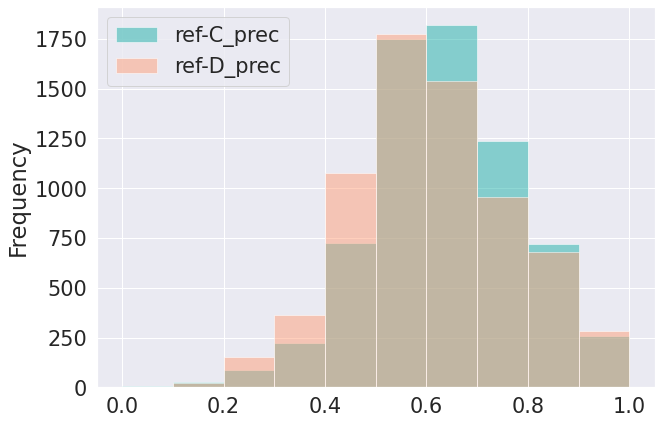

In [353]:
unique_ref_analysis_df[['ref-C_prec', 'ref-D_prec']].plot.hist(figsize=(10,7), alpha=0.5, 
                                                        color=['lightseagreen', 'lightsalmon'])

<AxesSubplot:ylabel='Frequency'>

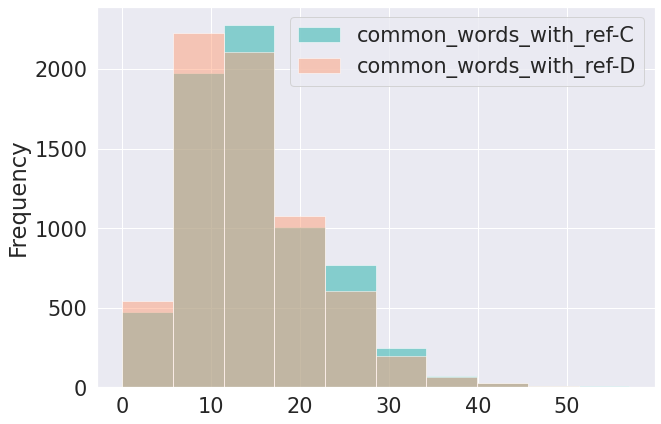

In [354]:
unique_ref_analysis_df[['common_words_with_ref-C', 'common_words_with_ref-D']].plot.hist(figsize=(10,7), alpha=0.5, 
                                                        color=['lightseagreen', 'lightsalmon'])

<AxesSubplot:xlabel='ref-C_len', ylabel='ref-D_len'>

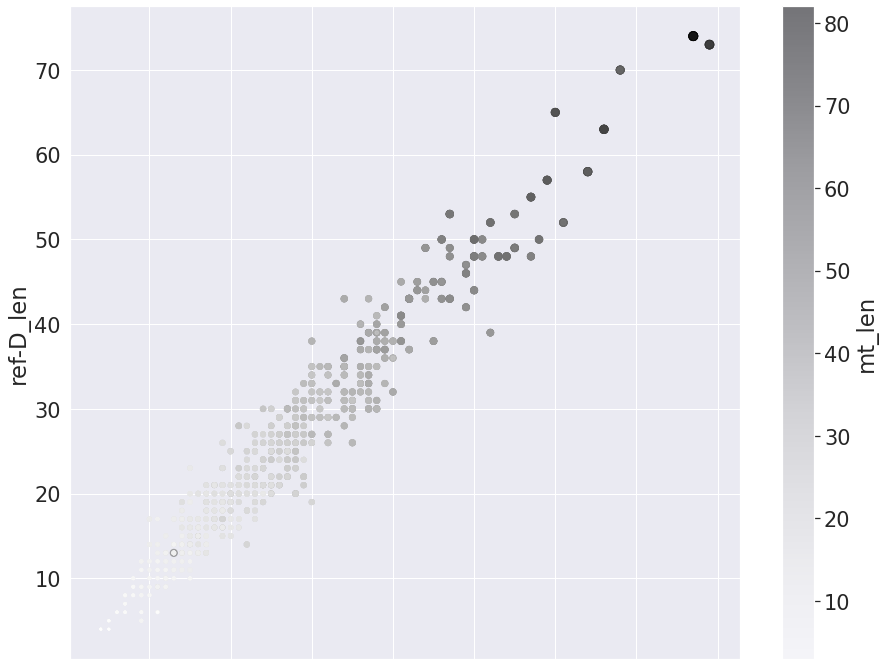

In [375]:
unique_ref_analysis_df.plot.scatter(x='ref-C_len', y='ref-D_len', figsize=(15,12), alpha=0.5, 
                                                        c='mt_len', s='mt_len')

<AxesSubplot:ylabel='Frequency'>

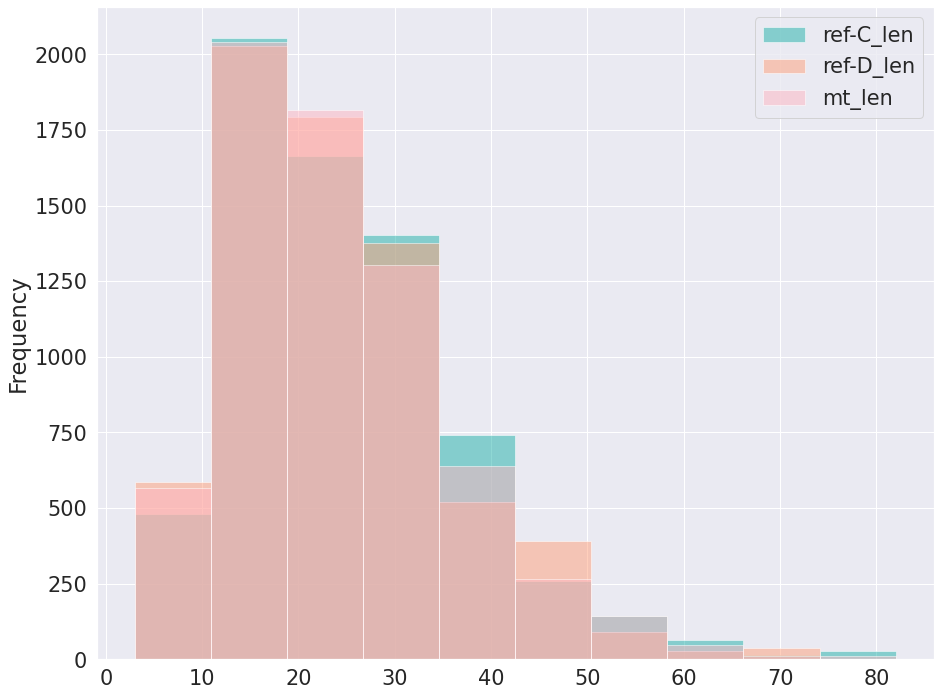

In [364]:
unique_ref_analysis_df[['ref-C_len', 'ref-D_len', 'mt_len']].plot.hist(figsize=(15,12), alpha=0.5, 
                                                        color=['lightseagreen', 'lightsalmon', 'lightpink'])

<AxesSubplot:ylabel='Frequency'>

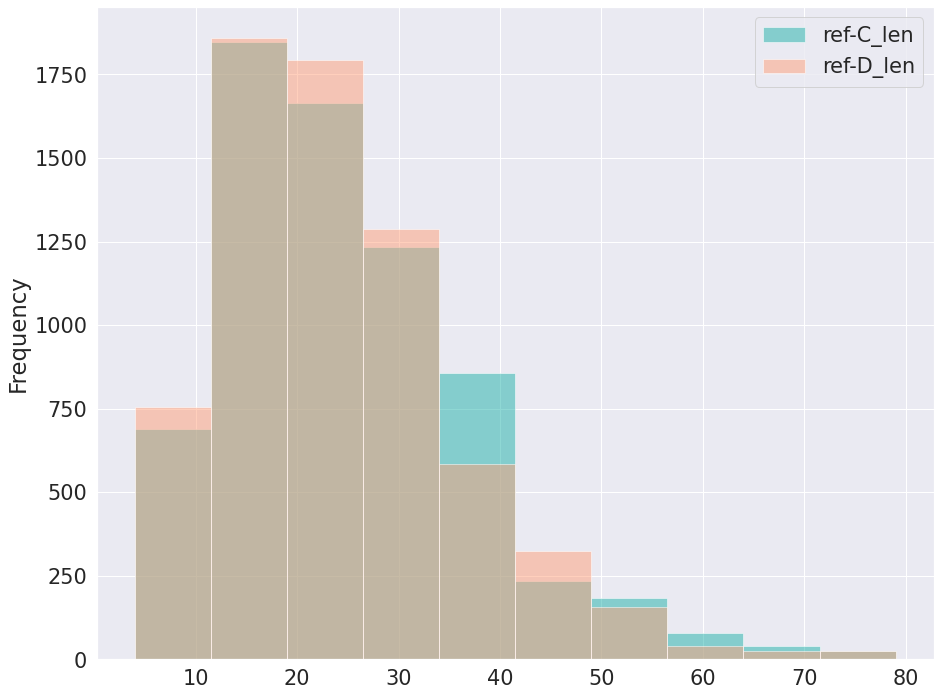

In [365]:
unique_ref_analysis_df[['ref-C_len', 'ref-D_len']].plot.hist(figsize=(15,12), alpha=0.5, 
                                                        color=['lightseagreen', 'lightsalmon'])

precision-based metrics can perform better on C since it contains more words and thus slightly larger chance to meet the same word as in hypothesis since we normalize anyway by the length of mt_output

recall-based metrics may perform better on ref D since there will be length penalty from reference length

<AxesSubplot:ylabel='Frequency'>

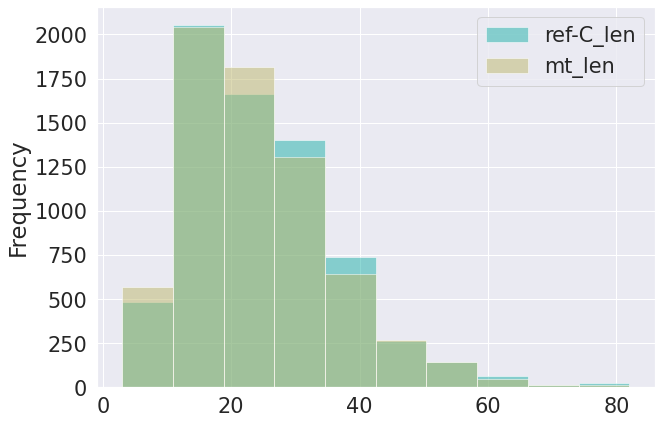

In [368]:
unique_ref_analysis_df[['ref-C_len', 'mt_len']].plot.hist(figsize=(10,7), alpha=0.5, 
                                                        color=['lightseagreen', 'darkkhaki'])

<AxesSubplot:ylabel='Frequency'>

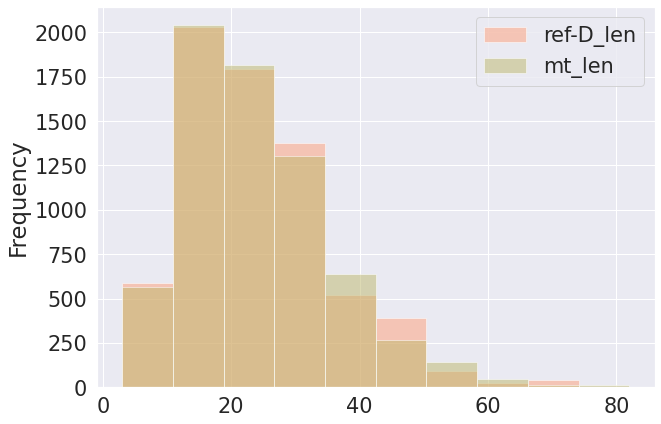

In [369]:
unique_ref_analysis_df[['ref-D_len', 'mt_len']].plot.hist(figsize=(10,7), alpha=0.5, 
                                                        color=['lightsalmon', 'darkkhaki'])